In [1414]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange
from copy import deepcopy
import minimize_lengths as mn
import recursive_lengths as rl
import pandas as pd
import imp
def connect_df(files):
    """Connect all pandas in files togetehr"""
    tmp = []
    for j in files:
        dtm = pd.read_csv('/scicore/home/nimwegen/rocasu25/Documents/Projects/biozentrum/MoM_constitExpr/20190612_forAthos/'+j+'/'+j+'.csv')
        dtm['date'] = j
        dtm['cell'] = dtm['date']+dtm['gl'].apply(lambda x: str(x))+dtm['id'].apply(lambda x: str(x))
        dtm['lane_ID'] = dtm['date']+dtm['lane_ID']
        tmp.append(dtm)
    return pd.concat(tmp)
def inference_prior(dftest,dftrain,leng='length_um',reg_ser=[None,1e3,1e6,1e9],resc=100):
    """Do inference in dftrain with different levels of the regularizer. Return parameters sets and the likelihood or the r2 of teh prediction on the test set """
    ret=[]
    dftest,in_dic_1 = rl.build_data_strucutre(dftest,leng,resc)
    dftrain,in_dic = rl.build_data_strucutre(dftrain,leng,resc)
    print("sm2={}, mlam={}".format(in_dic['sm2'],in_dic['s'][1,0]))
    mod = mn.minimize_lengths(free={'sl2':0.00002,'gamma':0.00125,'sm2':in_dic['sm2'],'m_lam':in_dic['s'][1,0]},fixed={})
    for re in reg_ser:
        tmp_ = mod.minimize(in_dic=in_dic,numerical=False,fun=rl.grad_obj_wrap,reg=re)
        tmp = tmp_['best_param']
        x=tmp['mlam'],tmp['gamma'],tmp['sl2'],tmp['sm2']
        cost = mod.tot_objective(x,in_dic=in_dic_1,fun=rl.cost_function)
        ll = rl.grad_obj_wrap(x,in_dic_1)
        print(x,-ll[0],cost[0])
        ret.append([x,-ll[0],cost[0],re])
    return ret
def inference_fix(df,in_dic,gammas=None, fixed=False,sz = 10):
    """Change manually what you want to fix"""
    if gammas is None: assert fixed==False
    else: assert fixed==True
    ret={'log_lik':-1e10}
    # create 10 different starting positions random
    mlams = np.random.normal(loc =in_dic['s'][1,0],scale=0.5*in_dic['s'][1,0],size=sz)
    if gammas is None:
        gams = np.random.normal(loc =0.01,scale=0.05*0.001,size=sz)
    else:
        gams = np.random.normal(loc =gammas,scale=0,size=sz)
    sm2s =  np.random.normal(loc =in_dic['sm2'],scale=0.5*in_dic['sm2'],size=sz)
    sl2s =  gams*mlams*0.5
    for mlam,gam,sl2,sm2 in list(zip(mlams,gams,sm2s,sl2s)):
        if fixed:
            try:
                mod = mn.minimize_lengths(free={'sl2':sl2,'sm2':sm2},fixed={'gamma':gam,'m_lam':in_dic['s'][1,0]})
                tmp = mod.minimize(in_dic=in_dic,numerical=False,fun=rl.grad_obj_wrap)
            except AssertionError:
                print("AssertionError try to increse rescaling")
                continue
            if ret['log_lik']<tmp['log_lik']:
                ret = tmp
        else:
            try:
                mod = mn.minimize_lengths(free={'sl2':sl2,'gamma':gam,'m_lam':mlam,'sm2':sm2},fixed={})
                tmp = mod.minimize(in_dic=in_dic,numerical=False,fun=rl.grad_obj_wrap)
            except AssertionError:
                print("AssertionError try to increse rescaling")
                continue
            if ret['log_lik']<tmp['log_lik']:
                ret = tmp          
    return tmp

from scipy.stats import linregress
def sleres(y,dt=3.,r2=False):
    """Return slope (lambda), intercept (x0) and residuals (form sm2)"""
    t = np.arange(0,len(y)*dt,dt)
    r = linregress(t,y)
    if r2:
        return r.rvalue
    else:
        return r.slope
def res(lrow):
    """Residuals"""
    time = np.arange(len(lrow))
    tmp = linregress(time,lrow)
    return lrow - (time*tmp.slope+tmp.intercept)

In [1415]:
## Asymmetric divison
def asym_dist_1lane(reind_,dat_,dt,rescale):
    """Find the asymmetric distribution in log space for one lane"""
    from scipy.stats import linregress
    from copy import deepcopy
    reind = deepcopy(reind_); dat = deepcopy(dat_)
    distx0 = []; distlam = []; distk0 = []           # total objective and gradient
    def pred_moth(i,j):
        """Predict division length and growth rate. Do same for inital one"""
        # Linear fit one cell cycle to estimate length mother and lenght daughter
        W=dat[i][1][j].reshape(-1); t = np.arange(0,dt*len(W),dt)
        tmp = linregress(t,W)
        tmp1 = linregress(t[:4],W[:4])
        tmp2 = linregress(t[:4],W[-4:])
        if np.isnan(reind[i,j]) == False:
            # predict cell lenght at division and el_rat
            foo = np.append(t,t[-1]+dt/2)*tmp.slope+tmp.intercept
            dat[int(reind[i,j])][0] = {'ml':foo[-1],'mlam':tmp2.slope}
        return tmp.intercept, tmp1.slope #x0 and lambda
    ## APPLY
    for i in range(len(dat)):
        # If cell doesn't have mother just predict length of daugther and save them
        if type(dat[i][0])!=dict:
            pred_moth(i,0);
            if np.sum(np.isnan(dat[i][1][1]))==0:
                pred_moth(i,1)
        # If it does has a mother predict its length and save the log  difference betwee half of mother cell and daugther one
        else:
            x0,lam = pred_moth(i,0)
            distx0.append(dat[i][0]['ml']-rescale*np.log(2)-x0)
            distlam.append(dat[i][0]['mlam']-lam)
            distk0.append([x0,lam])
            if np.sum(np.isnan(dat[i][1][1]))==0:
                x0,lam = pred_moth(i,1)
                distx0.append(dat[i][0]['ml']-rescale*np.log(2)-x0)
                distlam.append(dat[i][0]['mlam']-lam)
                distk0.append([x0,lam])
    return distx0, distlam, distk0
def asym_dist(reind_v,dat_v,dt,rescale):
    """Return distribution of difference between predictd half size and actual cell division (distx0); differene in growth rates between mother and daugheter (distlam); and initial condition (x,lam) distk0 """
    distx0 = []; distlam = []; distk0 =[] 
    for i,j in enumerate(dat_v):
        dx0 , dlam, dk0 = asym_dist_1lane(reind_v[i],dat_v[i],dt,rescale)
        distx0.append(dx0); distlam.append(dlam); distk0.append(dk0)
    flat = lambda dist: np.array([j for k in dist for j in k]) 
    return flat(distx0),flat(distlam), flat(distk0)

In [1416]:
def synt_stats_old(abv):
    """Create synthetic traces and infer parameters from them"""
    ret = []
    for j in range(abv.shape[0]):
        W,X = rl.integrated_ou(mlam=abv[j,0],gamma=abv[j,1],sl2=abv[j,2],sm2=abv[j,3],length=30,ncel=10000)
        la = np.apply_along_axis(sleres,1,W)
        ret.append(la)
    return np.vstack(ret)

In [1417]:
def synt_stats(abv,lcel=30):
    """Create synthetic traces and infer parameters from them"""
    ret = []
    for j in range(abv.shape[0]):
        W,X = rl.integrated_ou(mlam=abv[j,0],gamma=abv[j,1],sl2=abv[j,2],sm2=abv[j,3],length=lcel*10000,ncel=1)
        W=W.reshape(10000,lcel)
        la = np.apply_along_axis(sleres,1,W)
        ret.append(la)
    return np.vstack(ret)

In [1418]:
def par_array(df,in_dic,gammas=[0.01,0.001], sz = 1,gam_none=True):
    """Infer for different fixed gammas and return a numpy arry"""
    ret = []
    if gam_none:
        foo = inference_fix(df,in_dic,gammas=None, fixed=False,sz = sz)
        ret.append([foo['best_param']['mlam'],foo['best_param']['gamma'],foo['best_param']['sl2'],foo['best_param']['sm2'],foo['log_lik']])
    for g in gammas:
        foo = inference_fix(df,in_dic,gammas=g, fixed=True,sz = sz)
        ret.append([foo['best_param']['mlam'],foo['best_param']['gamma'],foo['best_param']['sl2'],foo['best_param']['sm2'],foo['log_lik']])
    return np.vstack(ret)

In [1419]:
def smilar_frame(W,cvd=0):
    """From  OU create a dataframe with same shape as biological data (divison at twice the size).. Consider also asymmetric division """
    explen = []; lane_ID=[]; parent_ID=[]; id_n=[-1]; time_sec=[]; df=[]
    W = deepcopy(W); 
    for i in range(W.shape[0]):
        tmp = [W[i,0]]
        fix = W[i,0]
        ts=[0]
        for k in range(1,W.shape[1]-1):
            #if tmp[-1] < tmp[0]+np.log(2):
            #Do the choice stocastically otherwise we accumulate always some lengths
            #print([W[i,k]< tmp[0]+np.log(2),W[i,k+1]< tmp[0]+np.log(2)])
            div = np.random.normal(np.log(2),np.log(2)*cvd)
            if np.random.choice([W[i,k]< fix+div,W[i,k+1]< fix+div],1,p=[0.5,0.5])[0]:
                tmp.append(W[i,k])
                ts.append(ts[-1]+180)
            else:
                lane_ID = ['lane_num_{}'.format(i)]*int(len(tmp))
                parent_ID = ['{}'.format(id_n[-1])]*int(len(tmp))
                id_n = ['{}'.format(k)]*int(len(tmp))
                explen= np.exp(tmp)
                time_sec = ts
                ts=[ts[-1]]         
                tmp = [tmp[-1]-div]
                W[i,:] = W[i,:]-div
                #print(len(explen))
                #print(len(lane_ID))
                df.append(pd.DataFrame({'leng':explen,'lane_ID':lane_ID,'parent_id':parent_ID, 'id':id_n,'time_sec':time_sec}))
    df = pd.concat(df,ignore_index=True)
    df['cell'] = df['lane_ID']+'_'+df['id']
    return df



In [1073]:
#def smilar_frame(W,cpl,lenc,ncel,cvd=0):
#    """From int OU create a dataframe with same shape as biological data.. Consider also asymmetric division"""
#    explen = []; lane_ID=[]; parent_ID=[]; id=[]; time_sec=[]
#    for i in range(W.shape[0]):
#        subW = (W[i,:]).reshape(cpl,int(W.shape[1]/cpl) )# IF WE DO CORRECTLY UNTIL CELL DIVISION MIGHT CHANGE
#        q=0;ts=0
#        for k in range(subW.shape[0]):
#            for j in range(subW.shape[1]):
#                lane_ID.append('lane_num_{}'.format(i))
#                parent_ID.append('{}'.format(k-1))
#                id.append('{}'.format(k))
#                explen.append(np.exp(subW[k,j]-q))
#                time_sec.append(ts)
#                ts+=180
#            #Asym cell division    
#           q=q+np.random.normal(np.log(2),np.log(2)*cvd)
#            #s = np.random.normal(loc=s-np.log(2),scale=np.sqrt(asy_divsg2))#deviation from perfect division; 
#    df = pd.DataFrame({'leng':explen,'lane_ID':lane_ID,'parent_id':parent_ID, 'id':id,'time_sec':time_sec})
#    df['cell'] = df['lane_ID']+'_'+df['id']
 #   return df

### 1) Load files

Take Dany's files on constitutive promoters and look only to glucose condition. We take all experiment together in order to have a larger dataset to avoid potential overfitting.

In [1543]:
#Load file
files = pd.read_csv('files.txt',header=None)
#Only gluc
filglu = [j  for j in files[0] if 'gluc'in j ]
# Connect them
df = connect_df(filglu)

In [1544]:
df.shape

(78605, 64)

Total number of datapoints 

In [1545]:
df = df.groupby('cell').filter(lambda x: sleres(np.log(x.length_um),r2=True)>0.98)

In [812]:
df.shape[0]/78605

0.8950575663125755

### 2) Basic analysis

Let's compute the slopes by exp fit and plot the statistics

In [1412]:
elrat = df.groupby('cell').apply(lambda x: sleres(np.log(x.length_um)))

Plot the histogram of a "prefect" Gaussian (blue) with the actual distribution (orange)

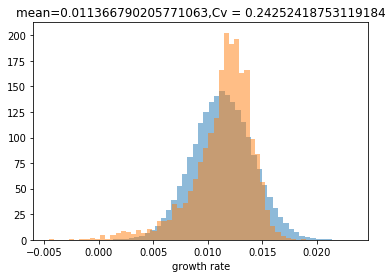

In [1079]:
_ = plt.hist(np.random.normal(loc=np.mean(elrat),scale=np.std(elrat),size=100000),bins=50,density=1,alpha=0.5)
_=plt.hist(elrat,bins=50,density=1,alpha=0.5)
plt.title("mean={},Cv = {}".format(np.mean(elrat),np.std(elrat)/np.mean(elrat)))
plt.xlabel('growth rate')
plt.savefig('distribution_dany_no_filter')

The distribution is clearly non Gaussin and we observe the accomulation of small growth rates. The Cv is around 25% and we can also compute the mean elongation rate and the distribution of residuals

In [220]:
print("mean elongation rate = {}".format(np.mean(elrat)))

mean elongation rate = 0.011753915754893077


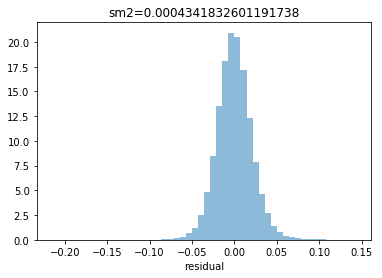

In [815]:
resid = df.groupby('cell').apply(lambda x: res(np.log(x.length_um)))
_=plt.hist(resid,bins=50,density=1,alpha=0.5)
_=plt.title("sm2={}".format(np.var(resid)))
plt.xlabel('residual')
plt.savefig('residualdist.png')

In [222]:
asym_dist_dat,_,_ = asym_dist(in_dic['reind_v'],in_dic['dat_v'],dt=3,rescale=1)

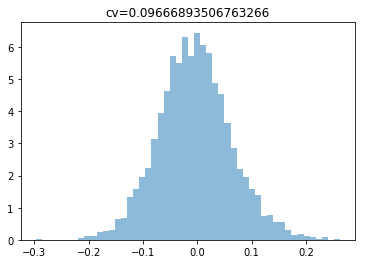

In [1299]:
_=plt.hist(asym_dist_dat,bins=50,density=1,alpha=0.5)
_=plt.title("cv={}".format(np.std(asym_dist_dat)/np.log(2)))
plt.savefig('asymdiv.png')

##### 3.1 Get rid of measurment 

In [1380]:
df = df.reset_index()

In [1381]:
tmp = (df['time_sec'].unique()[::2])
dfsh = pd.concat([df.loc[df['time_sec']==tmp[k]] for k in range(tmp.shape[0])])

In [1382]:
dfsh = dfsh.sort_index()

In [1383]:
dfsh,in_dicsh = rl.build_data_strucutre(dfsh,'length_um',100)

In [1420]:
abv_short = par_array(dfsh,in_dicsh,gammas=[1], sz = 2)

In [1385]:
abv_short

array([[ 1.10374468e+00,  1.64330288e+00,  5.61095792e+00,
         9.80044241e-01, -9.55943888e+04],
       [ 1.17544757e+00,  1.00000000e+00,  2.16649952e+00,
         1.25592087e+00, -9.58451070e+04],
       [ 1.17544757e+00,  1.00000000e-01,  3.33484489e-02,
         4.25000580e+00, -9.54012872e+04],
       [ 1.17544757e+00,  2.00000000e-02,  6.23770465e-03,
         5.51025775e+00, -9.57898987e+04],
       [ 1.17544757e+00,  1.00000000e-02,  4.87774200e-03,
         5.72030775e+00, -9.62136378e+04]])

### 3 Inference algorithm

Let's infere the best parameters settings [with fixing the gamma] using the algorithm, then generate an OU process with such parameters and compare with the actual distribution

In [1546]:
#Build correct dataset strucutre
df,in_dic = rl.build_data_strucutre(df,'length_um',1)

In [236]:
# Find different parameter settings for different fixed gammas
array_best_values = par_array(df,in_dic,gammas=[100,10,0.1,0.0125,0.0083,0.00625,0.005,0.004,0.003,0.0025,0.002], sz = 2)

In [226]:
# Save for future loads
#np.save('array_best_values',array_best_values)
#array_best_values = np.load('array_best_values.npy')

In [237]:
# Let's visualize in a table the output where mlam is the mean elongation rate, 1/gamma correlation time, sl2 the random kicks and sm2 the variance of gaussian error
pd.DataFrame(array_best_values,columns=('mlam','gamma','sl2','sm2','log_lik'))

,mlam,gamma,sl2,sm2,log_lik
0,0.015141,0.48332,1.168336e-04,1.722249e-04,145900.349149
1,0.011056,100.00000,1.869020e+00,1.040422e-04,152670.466228
2,0.011056,10.00000,1.869080e-02,1.124674e-04,152670.552987
3,0.011075,0.10000,4.521761e-06,3.311853e-04,151979.644657
4,0.011352,0.01250,1.480684e-06,3.907720e-04,148946.274337
5,0.011519,0.00830,1.435360e-06,3.926740e-04,148604.945652
6,0.011682,0.00625,1.418495e-06,3.934043e-04,148426.515334
7,0.011198,0.00500,2.931566e-07,7.904168e-04,-216609.948648
8,0.012055,0.00400,1.404787e-06,3.938914e-04,148221.423244
9,0.012398,0.00300,1.399122e-06,3.942628e-04,148127.111224


Someting get wrong in the minimization of gamma = [0.0025,0.1,0.0125]  since even mean elongation rate is off. Let's repeat it starting from new inital conditions

In [251]:
redoarray_best = par_array(df,in_dic,gammas=[0.1,0.0125], sz = 5,gam_none=False)

In [252]:
#Save under new array
newarray = np.vstack((np.delete(array_best_values,[3,4],0),redoarray_best))

In [253]:
pd_newarray = pd.DataFrame(newarray,columns=('mlam','gamma','sl2','sm2','log_lik'))

In [255]:
pd_newarray['tau'] = 1/pd_newarray['gamma']

In [360]:
pd_newarray#.to_csv('inf_on_dany.csv')

,mlam,gamma,sl2,sm2,log_lik,tau
0,0.015141,0.48332,1.168336e-04,1.722249e-04,145900.349149,2.069022
1,0.011056,100.00000,1.869020e+00,1.040422e-04,152670.466228,0.010000
2,0.011056,10.00000,1.869080e-02,1.124674e-04,152670.552987,0.100000
3,0.011519,0.00830,1.435360e-06,3.926740e-04,148604.945652,120.481928
4,0.011682,0.00625,1.418495e-06,3.934043e-04,148426.515334,160.000000
5,0.011198,0.00500,2.931566e-07,7.904168e-04,-216609.948648,200.000000
6,0.012055,0.00400,1.404787e-06,3.938914e-04,148221.423244,250.000000
7,0.012398,0.00300,1.399122e-06,3.942628e-04,148127.111224,333.333333
8,0.019730,0.00250,1.412287e-06,3.936356e-04,148056.242351,400.000000
9,0.334126,0.00200,1.419503e-04,7.494933e-07,-55417.350269,500.000000


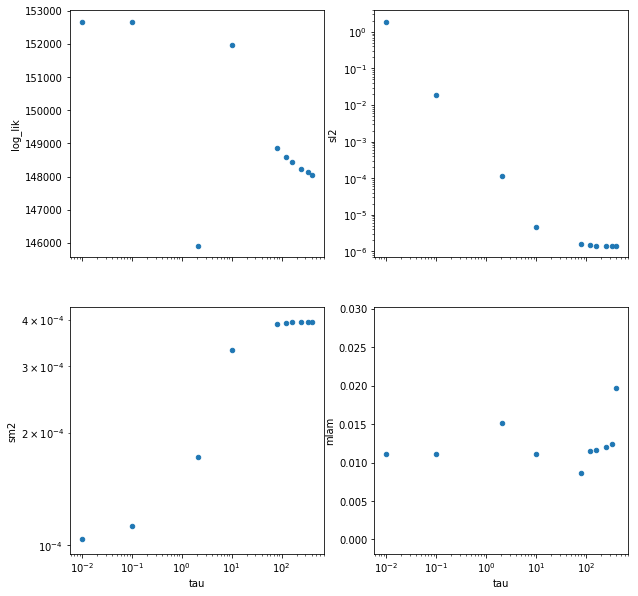

In [362]:
pdfilt = pd_newarray.loc[pd_newarray['log_lik']>0]
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)
pdfilt.plot(x='tau',y='log_lik',kind='scatter',logx=True,ax=axs[0,0],sharex=True)
pdfilt.plot(x='tau',y='sl2',kind='scatter',logx=True,logy=True,ax=axs[0,1],sharex=True)
pdfilt.plot(x='tau',y='sm2',kind='scatter',logx=True,logy=True,ax=axs[1,0],sharex=True)
pdfilt.plot(x='tau',y='mlam',kind='scatter',logx=True,logy=False,ax=axs[1,1],sharex=True)
fig.savefig('Model_on_dany')

Out of the outlier at 10^0 ( which is probably due to minimisation reasons) the algo predict a better model for short correlation times (1/gamma), small measurment errors (sm2) and large biological one (sl2). 

#### 4) Sintethic statistics

I generate integrated OU process with 30 datapoints (average datapoints number per cell cicle in experiments) with all these parameters, do linear fit over this sythetic traces an compare the results with the experiment.

In [272]:
nwa = newarray[np.repeat(newarray[:,4:]>0,5,axis=1)]

In [277]:
nwa = nwa.reshape((int(len(nwa)/5),5))

In [1098]:
tmp = synt_stats(nwa)

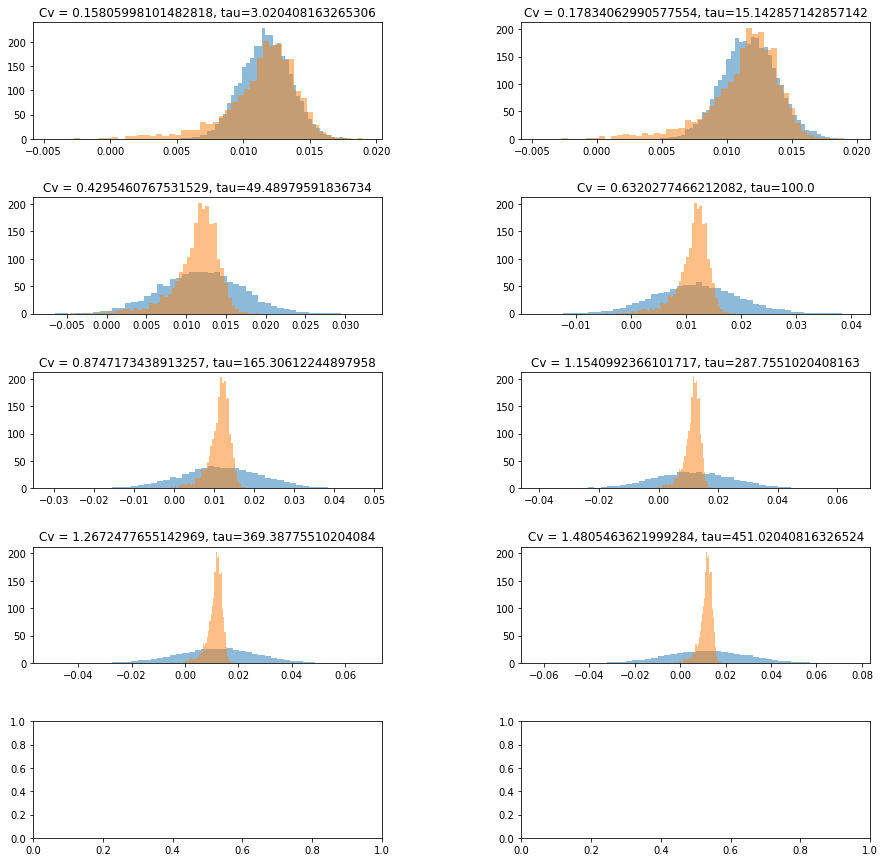

In [1099]:
fig, axs = plt.subplots(nrows=5,ncols=2)
fig.set_figwidth(15)
fig.set_figheight(15)
plt.subplots_adjust(wspace=0.4,hspace=0.5)
i=j=0
for k in range(tmp.shape[0]):    
    axs[i,j].hist(tmp[k,:],bins=50,density=1,alpha=0.5)
    axs[i,j].hist(elrat,bins=50,density=1,alpha=0.5)
    axs[i,j].set_title("Cv = {}, tau={}".format(np.std(tmp[k,:])/np.mean(tmp[k,:]),1/nwa[k,1]))
    if j%2==0:
        j=1
    else:
        i+=1; j=0
#fig.savefig('simulated_ou_proc')

Clearly none of the inferred parameters gives back the same statistics as the experimental data showing that our inference model is wrong. Now we do have 2 options:
-1) We have some bugs
-2) Something conceptual about our model is wrong
The first is easy to verify

#### Bugs?

Build panda in the same format as in experimantal data (just 1 cell)

In [433]:
# Integrated (W) and simple Ou (X) for 10 lane (ncel) and 10 cell per lane (30*cell_per_lane)
cpl=1; lenc = 10000; ncel = 1
W,X = rl.integrated_ou(mlam=0.01,gamma=0.02,sl2=2e-06,sm2=0.0002,length=lenc*cpl,ncel=ncel)

In [434]:
#give same panda structure as in experimental data
dfsy = smilar_frame(W,cpl,lenc,ncel)

In [435]:
#Create format
dfsy,in_dic_sy = rl.build_data_strucutre(dfsy,'leng',1)

In [437]:
#minimize
mlam=0.01;gam=0.02;sl2=2e-06;sm2=0.0002
mod = mn.minimize_lengths(free={'sl2':sl2,'m_lam':mlam,'sm2':sm2,'gamma':gam},fixed={})
tmp = mod.minimize(in_dic=in_dic_sy,numerical=False,fun=rl.grad_obj_wrap)
print(tmp)

{'log_lik': 22460.789696804728, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'status': 0, 'success': True, 'best_param': {'sm2': 0.00025313384314232864, 'mlam': 0.010000010081663728, 'sl2': 2.440223174771653e-06, 'gamma': 0.02000004788267128}, 'jac': array([ -796.97919944, -2450.87959705,    30.40404284,     2.64978842])}


In [439]:
#The objective at the "optimal" point is
mod.tot_grad_obj((0.01,0.02,2e-06,0.0002),in_dic_sy)

(-22321.999074704272,
 array([-9.72609251e+02,  1.25073947e+02, -1.47802716e+08, -4.87398871e+06]))

The inferred results are very close to the one used to generate the process! Actually if we take the numerical mean and variance of the OU process the infered one are even better

In [438]:
print("Numerical",'mean',np.mean(X),'var', np.var(X))
print("Inferred",'mean',tmp['best_param']['mlam'],'var',tmp['best_param']['sl2']/(2*tmp['best_param']['gamma']))
print("Theoreticals",'mean',0.01,'var',2e-06/(2*0.02))

Numerical mean 0.010142818816589846 var 4.957198938577525e-05
Inferred mean 0.010000010081663728 var 6.100543331413584e-05
Theoreticals mean 0.01 var 4.9999999999999996e-05


**With cell division** but no asymmetric division

In [1074]:
# Integrated (W) and simple Ou (X) for 10 lane (ncel) and 10 cell per lane (30*cell_per_lane)
cpl=10; lenc = 25; ncel = 40
W,X = rl.integrated_ou(mlam=0.01,gamma=0.02,sl2=2e-06,sm2=0,length=lenc*cpl,ncel=ncel)
dfsy = smilar_frame(W)
dfsy['leng'] = dfsy['leng'].apply(lambda x: np.exp(np.random.normal(np.log(x),np.sqrt(sm2))))
dfsy,in_dic_sy = rl.build_data_strucutre(dfsy,'leng',1)

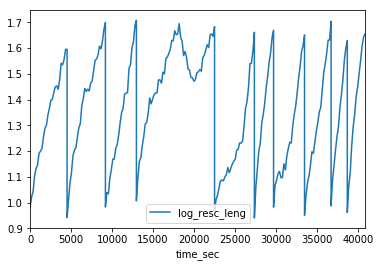

In [1089]:
dfsy.loc[dfsy['lane_ID']=='lane_num_3'].plot(x='time_sec',y='log_resc_leng')

Note that with bulk parameters we might have negative growth (not observing them can be one cause)

In [1092]:
mlam=0.01;gam=0.02;sl2=2e-06;sm2=0.0002
mod = mn.minimize_lengths(free={'sl2':sl2*3,'m_lam':mlam*10,'sm2':sm2*2,'gamma':gam*10},fixed={})
tmp = mod.minimize(in_dic=in_dic_sy,numerical=False,fun=rl.grad_obj_wrap)
print(tmp)

{'jac': array([ 3.90107544e+04,  1.34260568e+04, -1.31437246e+08,  6.66172269e+05]), 'success': True, 'best_param': {'sl2': 3.397154435156326e-06, 'mlam': 0.011205755328520292, 'gamma': 0.07054010054196184, 'sm2': 0.0002937839007915677}, 'log_lik': 19846.30196129782, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'}


In [1094]:
mod.tot_grad_obj((mlam,gam,sl2,sm2),in_dic_sy)

(-19901.075341021373,
 array([-2.26859557e+03, -9.62654947e+02, -9.26218694e+07, -6.60198911e+06]))

This also works fine let's now look with asymmetric division

##### Asymmetric cell division (can be one source of error see this paragraph)

Coefficient of variation for asymmetric cell division cvd=0.1

In [1301]:
# Integrated (W) and simple Ou (X) for 10 lane (ncel) and 10 cell per lane (30*cell_per_lane)
cpl=40; lenc = 25; ncel = 30
W,X = rl.integrated_ou(mlam=0.01,gamma=0.02,sl2=2e-06,sm2=0,length=lenc*cpl,ncel=ncel)
dfsy = smilar_frame(W,cvd=0.1)
dfsy['leng'] = dfsy['leng'].apply(lambda x: np.exp(np.random.normal(np.log(x),np.sqrt(sm2))))
dfsy,in_dic_sy = rl.build_data_strucutre(dfsy,'leng',1)

In [1302]:
asym_dist_dat_sy,_,_ = asym_dist(in_dic_sy['reind_v'],in_dic_sy['dat_v'],dt=3,rescale=1)

Text(0.5, 1.0, 'Cv=-1.1284424777944004')

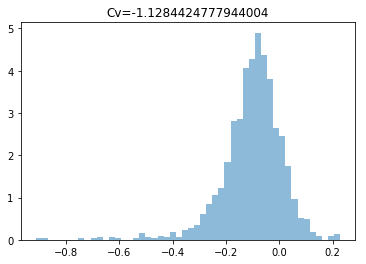

In [1306]:
_=plt.hist(asym_dist_dat_sy,alpha=0.5,density=1,bins=50)
plt.title("Cv={}".format(np.std(asym_dist_dat_sy)/np.mean(asym_dist_dat_sy)))

In [679]:
mlam=0.01;gam=0.02;sl2=2e-06;sm2=0.0002
mod = mn.minimize_lengths(free={'sl2':sl2,'m_lam':mlam,'sm2':sm2,'gamma':gam},fixed={})
tmp = mod.minimize(in_dic=in_dic_sy,numerical=False,fun=rl.grad_obj_wrap)
print(tmp)

{'jac': array([ -4014.04221725, -11872.25996022,  10149.48089166,     80.14639986]), 'success': True, 'best_param': {'sl2': 3.153983092409533e-06, 'mlam': 0.010000018329560935, 'gamma': 0.020000096098594218, 'sm2': 0.00028808790637465515}, 'log_lik': 64818.33151929077, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'}


In [ ]:
#Series of gamma 
#asy_cdv01 = par_array(dfsy,in_dic_sy,gammas=1/np.linspace(1,100,20), sz = 1)
#np.save('asy_cdv01.npy',asy_cdv01)

In [672]:
asy_cdv01 = np.load('asy_cdv01.npy')

In [674]:
asy_cdv01_array = pd.DataFrame(asy_cdv01,columns=('mlam','gamma','sl2','sm2','log_lik'))

/scicore/home/nimwegen/fiori/MoMA_predictions/MoMa_pred/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


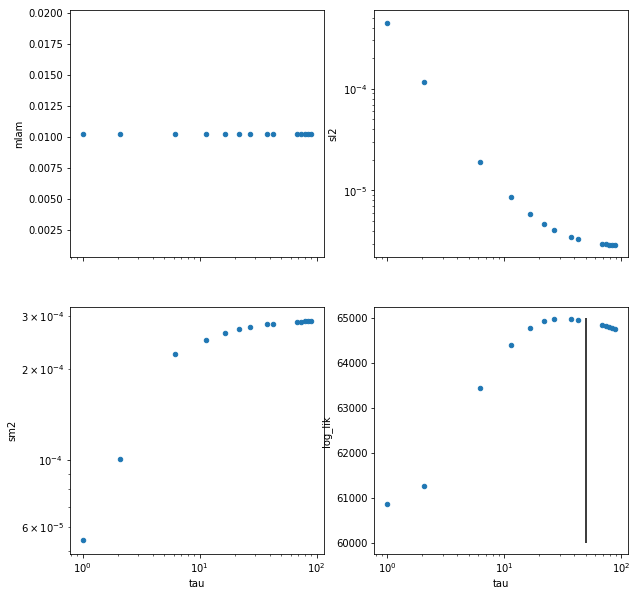

In [707]:
pdfilt = asy_cdv01_array.loc[asy_cdv01_array['log_lik']>40000,:]
pdfilt['tau']=1/pdfilt['gamma']
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)
pdfilt.plot(x='tau',y='log_lik',kind='scatter',logx=True,ax=axs[1,1],sharex=True)
pdfilt.plot(x='tau',y='sl2',kind='scatter',logx=True,logy=True,ax=axs[0,1],sharex=True)
pdfilt.plot(x='tau',y='sm2',kind='scatter',logx=True,logy=True,ax=axs[1,0],sharex=True)
pdfilt.plot(x='tau',y='mlam',kind='scatter',logx=True,logy=False,ax=axs[0,0],sharex=True)
plt.vlines(50,60000,65000)
fig.savefig('asy_cdv01.png')

Still robust!

Coefficient of variation for asymmetric cell division cvd=0.3

In [ ]:
cpl=40; lenc = 25; ncel = 30
W,X = rl.integrated_ou(mlam=0.01,gamma=0.02,sl2=2e-06,sm2=0,length=lenc*cpl,ncel=ncel)
dfsy = smilar_frame(W,cpl,lenc,ncel,cvd=0.3)
dfsy['leng'] = dfsy['leng'].apply(lambda x: np.exp(np.random.normal(np.log(x),np.sqrt(sm2))))
dfsy,in_dic_sy = rl.build_data_strucutre(dfsy,'leng',1)

In [ ]:
#series of gammas
asy_cdv03 = par_array(dfsy,in_dic_sy,gammas=1/np.linspace(1,100,20), sz = 1)
np.save('asy_cdv03.npy',asy_cdv03)

In [206]:
mlam=0.01;gam=0.02;sl2=2e-06;sm2=0.0002
mod = mn.minimize_lengths(free={'sl2':sl2,'m_lam':mlam,'sm2':sm2,'gamma':gam},fixed={})
tmp = mod.minimize(in_dic=in_dic_sy,numerical=False,fun=rl.grad_obj_wrap)
print(tmp)

{'jac': array([ 7.14169043e-02,  4.00532198e-03, -1.31328122e+01, -4.38922704e+00]), 'success': True, 'best_param': {'sl2': 4.678115249988873e-05, 'mlam': 0.01033069677121091, 'gamma': 0.15547745442432187, 'sm2': 0.0007457070099983183}, 'log_lik': 47166.10546148455, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'}


In [207]:
mod.tot_grad_obj((mlam,gam,sl2,sm2),in_dic_sy)

(-8079.799651449661,
 array([-6.38418261e+03,  3.54637188e+04, -8.68488438e+09, -2.25917762e+08]))

Here it break downs! However in our data we don't have a so large deviation in division. Anyway let's see how it behaves for very short gammas

In [208]:
abvsy = par_array(dfsy,in_dic_sy,gammas=[100,10,0.1,0.02,0.01,0.001], sz = 1)

In [209]:
pd.DataFrame(abvsy,columns=('mlam','gamma','sl2','sm2','log_lik'))

,mlam,gamma,sl2,sm2,log_lik
0,0.010331,0.15548,0.000047,7.457059e-04,47166.105461
1,0.010329,100.00000,8.774930,1.000000e-13,46468.389863
2,0.010329,10.00000,0.090291,1.000000e-13,46503.084517
3,0.010332,0.10000,0.000028,8.196598e-04,47084.927397
4,0.010356,0.02000,0.000013,9.581271e-04,46049.498109
5,0.010386,0.01000,0.000012,9.683069e-04,45716.392830
6,0.000108,0.00100,0.000012,9.719017e-04,45351.421795


/scicore/home/nimwegen/fiori/MoMA_predictions/MoMa_pred/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


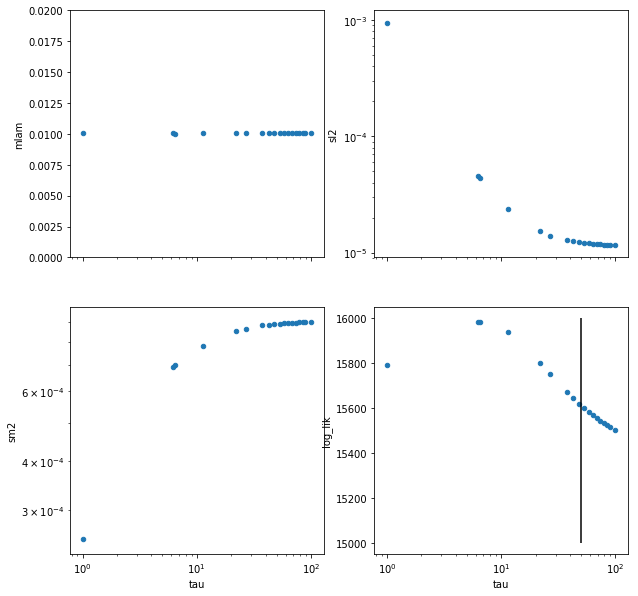

In [706]:
asy_cdv03 = np.load('asy_cdv03.npy')
asy_cdv03_array = pd.DataFrame(asy_cdv03,columns=('mlam','gamma','sl2','sm2','log_lik'))
pdfilt = asy_cdv03_array.loc[asy_cdv03_array['log_lik']>0,:]
pdfilt['tau']=1/pdfilt['gamma']
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)
pdfilt.plot(x='tau',y='log_lik',kind='scatter',logx=True,ax=axs[1,1],sharex=True)
pdfilt.plot(x='tau',y='sl2',kind='scatter',logx=True,logy=True,ax=axs[0,1],sharex=True)
pdfilt.plot(x='tau',y='sm2',kind='scatter',logx=True,logy=True,ax=axs[1,0],sharex=True)
pdfilt.plot(x='tau',y='mlam',kind='scatter',logx=True,logy=False,ax=axs[0,0],sharex=True)
plt.vlines(50,15000,16000)
fig.savefig('asy_cdv03.png')

### Correlated error

Perfect division but error coming from another OU process 

In [ ]:
# Integrated (W) and simple Ou (X) for 10 lane (ncel) and 10 cell per lane (30*cell_per_lane)
cpl=10; lenc = 25; ncel = 40
W,X = rl.integrated_ou(mlam=0.01,gamma=0.02,sl2=2e-06,sm2=0,length=lenc*cpl,ncel=ncel)
dfsy = smilar_frame(W,cpl,lenc,ncel)
Xerr = rl.ornstein_uhlenbeck(mlam=0.,gamma=0.1,sl2=sm2*2*0.1,length=lenc*cpl*ncel,ncel=1)
dfsy['leng'] = np.exp(np.log(dfsy['leng'].values)+Xerr).reshape(-1)
dfsy,in_dic_sy = rl.build_data_strucutre(dfsy,'leng',1)

In [ ]:
#series of gammas
corr_err_small = par_array(dfsy,in_dic_sy,gammas=1/np.linspace(1,100,20), sz = 1)
np.save('corr_err_small.npy',corr_err_small)

In [171]:
mlam=0.01;gam=0.02;sl2=2e-06;sm2=0.0002
mod = mn.minimize_lengths(free={'sl2':sl2,'m_lam':mlam,'sm2':sm2,'gamma':gam},fixed={})
tmp = mod.minimize(in_dic=in_dic_sy,numerical=False,fun=rl.grad_obj_wrap)
print(tmp)

{'jac': array([  996.67753301, -6107.21712201,  -746.85562924,    -9.74024719]), 'success': True, 'best_param': {'sl2': 3.5289350217675153e-06, 'mlam': 0.009999977339531445, 'gamma': 0.020000030188821294, 'sm2': 4.8618641296998104e-05}, 'log_lik': 27255.93270649708, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'}


In [ ]:
corr_err_small = np.load('corr_err_small.npy')

/scicore/home/nimwegen/fiori/MoMA_predictions/MoMa_pred/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


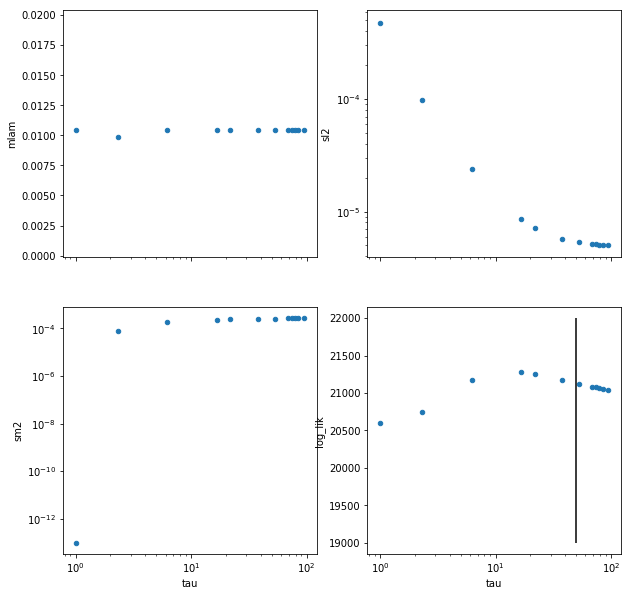

In [703]:
corr_err_small = np.load('corr_err_small.npy')
corr_err_small_array = pd.DataFrame(corr_err_small,columns=('mlam','gamma','sl2','sm2','log_lik'))
pdfilt = corr_err_small_array.loc[corr_err_small_array['log_lik']>16000,:]
pdfilt['tau']=1/pdfilt['gamma']
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)
pdfilt.plot(x='tau',y='log_lik',kind='scatter',logx=True,ax=axs[1,1],sharex=True)
pdfilt.plot(x='tau',y='sl2',kind='scatter',logx=True,logy=True,ax=axs[0,1],sharex=True)
pdfilt.plot(x='tau',y='sm2',kind='scatter',logx=True,logy=True,ax=axs[1,0],sharex=True)
pdfilt.plot(x='tau',y='mlam',kind='scatter',logx=True,logy=False,ax=axs[0,0],sharex=True)
plt.vlines(50,19000,22000)
fig.savefig('corr_err_small.png')

Looks robust! Try With bigger noise 

In [176]:
# Integrated (W) and simple Ou (X) for 10 lane (ncel) and 10 cell per lane (30*cell_per_lane)
cpl=10; lenc = 25; ncel = 40
W,X = rl.integrated_ou(mlam=0.01,gamma=0.02,sl2=2e-06,sm2=0,length=lenc*cpl,ncel=ncel)
dfsy = smilar_frame(W,cpl,lenc,ncel)
Xerr = rl.ornstein_uhlenbeck(mlam=0.,gamma=0.1,sl2=sm2,length=lenc*cpl*ncel,ncel=1)
dfsy['leng'] = np.exp(np.log(dfsy['leng'].values)+Xerr).reshape(-1)
dfsy,in_dic_sy = rl.build_data_strucutre(dfsy,'leng',1)
mlam=0.01;gam=0.02;sl2=2e-06;sm2=0.0002
mod = mn.minimize_lengths(free={'sl2':sl2,'m_lam':mlam,'sm2':sm2,'gamma':gam},fixed={})
tmp = mod.minimize(in_dic=in_dic_sy,numerical=False,fun=rl.grad_obj_wrap)
print(tmp)

{'jac': array([ 5.71666795e-01,  1.70081761e-01, -1.92315666e+03,  2.73140783e+01]), 'success': True, 'best_param': {'sl2': 1.2533990198876151e-05, 'mlam': 0.009762095844598888, 'gamma': 0.09051504798439723, 'sm2': 0.00021245227922196802}, 'log_lik': 21272.813265775967, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'}


Now it really goes to fit the noise! The likelihood for the model we had in mind changes a lot!

In [177]:
mod.tot_grad_obj((mlam,gam,sl2,sm2),in_dic_sy)

(-20210.289425579464,
 array([ 1.56375077e+03,  1.00681590e+03, -6.37184846e+08, -9.79695467e+06]))

Let's see how it behaves for small fixed gammas

In [186]:
abvsy = par_array(dfsy,in_dic_sy,gammas=[100,10,0.1,0.02,0.01], sz = 1)

In [188]:
pd.DataFrame(abvsy,columns=('mlam','gamma','sl2','sm2','log_lik'))

,mlam,gamma,sl2,sm2,log_lik
0,0.009236,0.804993,0.000340,4.306837e-06,20731.842108
1,0.009772,100.000000,3.270136,1.000000e-13,20334.951663
2,0.009772,10.000000,0.033405,1.000000e-13,20382.883206
3,0.009763,0.100000,0.000014,2.071816e-04,21271.199913
4,0.001714,0.020000,0.000102,1.713559e-05,7971.597654
5,0.009715,0.010000,0.000005,2.628536e-04,20963.588084


Redo inferecne for 0.02 since didn't work

In [190]:
abvsy = par_array(dfsy,in_dic_sy,gammas=[0.02], sz = 1)

In [191]:
pd.DataFrame(abvsy,columns=('mlam','gamma','sl2','sm2','log_lik'))

,mlam,gamma,sl2,sm2,log_lik
0,0.009789,0.583372,0.000197,0.000019,20726.859995
1,0.009742,0.020000,0.000006,0.000259,21063.153468


/scicore/home/nimwegen/fiori/MoMA_predictions/MoMa_pred/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


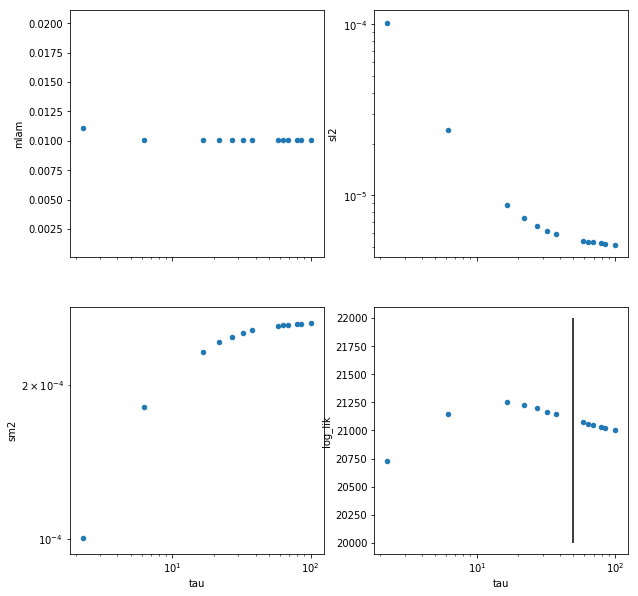

In [1214]:
corr_err_large = np.load('corr_err_large.npy')
corr_err_large_array = pd.DataFrame(corr_err_large,columns=('mlam','gamma','sl2','sm2','log_lik'))
pdfilt = corr_err_large_array.loc[corr_err_large_array['log_lik']>16000,:]
pdfilt['tau']=1/pdfilt['gamma']
pdfilt = pdfilt.loc[pdfilt['tau']>1,:]
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)
pdfilt.plot(x='tau',y='log_lik',kind='scatter',logx=True,ax=axs[1,1],sharex=True)
pdfilt.plot(x='tau',y='sl2',kind='scatter',logx=True,logy=True,ax=axs[0,1],sharex=True)
pdfilt.plot(x='tau',y='sm2',kind='scatter',logx=True,logy=True,ax=axs[1,0],sharex=True)
pdfilt.plot(x='tau',y='mlam',kind='scatter',logx=True,logy=False,ax=axs[0,0],sharex=True)
plt.vlines(50,20000,22000)
#fig.savefig('corr_err_large.png')

We also point out that in such scenarios the "free" optimization often doesn't work (or better it gives back local minima)

#### Conclusion 

Correlated errors and asymmetric division give both rise to wrong inferences if their effect is strong enough. Both of these potential source of errors are solved by our algorithm trough reducing the gamma value (i.e. reduce as much as it is possible the correlation time). We first notice that for the asymmetric cell division to break it is needed a cv=.3 which is 3 fold higher than the one observed in our data. However, for the correlated noise we are more in the expected regime. Note also that for correlated noise, fitting the noise is definetly the "best" solution but the second optima is given by the "real" biological correlation. This is not true for asymmetric division where it doesn't exist a second optima. We also note that the sm2 is, for the case of the correlated error, best when it matches the one used fro generating the model however for asymmetric division it try to give a larger measurment error. First let's fix measurment error and mean growth rate, and deeply optimize with fixed gamma to see if we find a second optima

# Go deeper

Go deeper in the region close to gamma=0.1 to see if it is really an optimum

In [ ]:
deeper = par_array(df,in_dic,gammas=1/np.linspace(1,100,50), sz = 2)

In [658]:
deep_array = pd.DataFrame(deeper,columns=('mlam','gamma','sl2','sm2','log_lik'))

In [343]:
deep_array['tau']=1/deep_array['gamma']

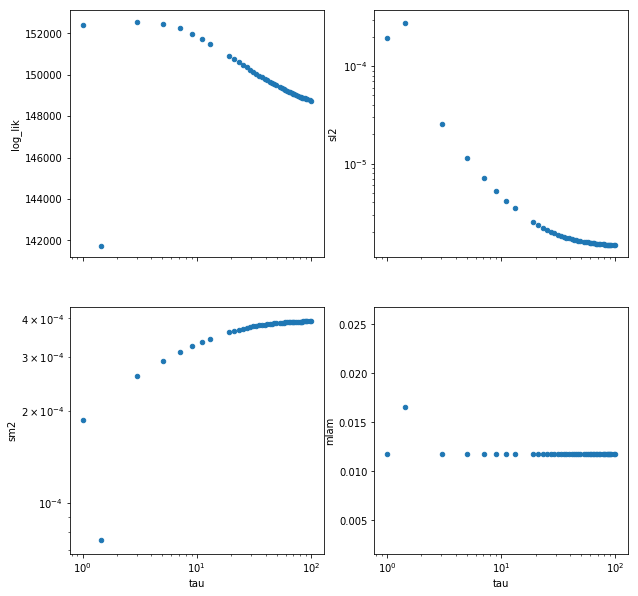

In [361]:
pdfilt = deep_array .loc[deep_array ['log_lik']>140000]
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)
pdfilt.plot(x='tau',y='log_lik',kind='scatter',logx=True,ax=axs[0,0],sharex=True)
pdfilt.plot(x='tau',y='sl2',kind='scatter',logx=True,logy=True,ax=axs[0,1],sharex=True)
pdfilt.plot(x='tau',y='sm2',kind='scatter',logx=True,logy=True,ax=axs[1,0],sharex=True)
pdfilt.plot(x='tau',y='mlam',kind='scatter',logx=True,logy=False,ax=axs[1,1],sharex=True)
fig.savefig('Model_on_dany_deep')

Fix mlam somthing is going wrong with the minimization

In [347]:
deep_array # saved as  deep_array_danysdata.csv 

,mlam,gamma,sl2,sm2,log_lik,tau
0,0.016591,0.695081,2.794716e-04,0.000076,141712.317284,1.438681
1,0.011754,1.000000,1.941773e-04,0.000187,152421.495317,1.000000
2,0.011754,0.331081,2.560176e-05,0.000260,152570.201849,3.020408
3,0.011754,0.198381,1.141214e-05,0.000291,152463.911731,5.040816
4,0.011754,0.141618,7.114238e-06,0.000310,152239.989721,7.061224
5,0.011754,0.110112,5.179564e-06,0.000325,151988.363388,9.081633
6,0.011754,0.090074,4.118935e-06,0.000335,151741.265579,11.102041
7,0.011754,0.076205,3.464692e-06,0.000344,151509.659818,13.122449
8,0.011754,0.066038,1.649403e-06,0.000457,-154108.086380,15.142857
9,0.011754,0.058264,1.523240e-06,0.000505,-144085.023207,17.163265


In [349]:
tmp1 = synt_stats(deep_array.values[2:3,:])

In [ ]:
plt.hist(tmp1,bins=50,density=1,alpha=0.5)
plt.hist(elrat,bins=50,density=1,alpha=0.5)
plt.set_title("Cv = {}, tau={}".format(np.std(tmp1)/np.mean(tmp1),1/deep_array.values[2:3,1:2]))

In [ ]:
plt.hist(tmp1,bins=50,density=1,alpha=0.5)

In [353]:
deep_array.to_csv('deep_array_danysdata')

# Long fluctuations

In [638]:
def genalogy(df,gen_deg='parent_cell'):
    """find one geanolgy upper"""
    for k in df.cell.unique():
        daug = df.loc[df['cell']==k] #daug
        gmum = df.loc[df['cell']==daug['{}'.format(gen_deg)].iloc[0]]['parent_cell'] #grand grand mum
        
        try:
            df.loc[df['cell']==k,'g_'+'{}'.format(gen_deg)] = gmum.iloc[0]
        except IndexError:
            df.loc[df['cell']==k,'g_'+'{}'.format(gen_deg)] = 'nan'
    return df

In [594]:
def corr_par(df,elrat,par_deg='parent_cell'):
    ret=[]
    for k in df.cell.unique():
        try:
            mum = elrat.loc[k]
            daug = elrat.loc[df.loc[df['cell']==k]['{}'.format(par_deg)].iloc[0]]
            ret.append([mum,daug])
        except KeyError:
            continue
    tmp = np.array(ret)
    return np.corrcoef(tmp[:,:1].reshape(-1),tmp[:,1:].reshape(-1))[0,1], tmp.shape[0]

In [ ]:
def syntetic_corr_gen(mlam,gamma,sl2,sm2):
    cpl=40; lenc = 25; ncel = 20
    W,X = rl.integrated_ou(mlam,gamma,sl2,sm2=0,length=cpl*lenc,ncel=ncel)
    dfsy = smilar_frame(W,cpl,lenc,ncel,cvd=0.)
    dfsy['leng'] = dfsy['leng'].apply(lambda x: np.exp(np.random.normal(np.log(x),np.sqrt(sm2))))
    dfsy,in_dic_sy = rl.build_data_strucutre(dfsy,'leng',1)
    dfsy['parent_cell'] = dfsy['lane_ID']+'_'+dfsy['parent_id']
    dfsy = genalogy(dfsy,'parent_cell')
    dfsy = genalogy(dfsy,'g_parent_cell')
    dfsy = genalogy(dfsy,'g_g_parent_cell')
    dfsy = genalogy(dfsy,'g_g_g_parent_cell')
    elratsy = dfsy.groupby('cell').apply(lambda x: sleres(x.log_resc_leng))
    corr_long = np.vstack([corr_par(dfsy,elratsy,par_deg=k) for k in ['parent_cell','g_parent_cell','g_g_parent_cell','g_g_g_parent_cell','g_g_g_g_parent_cell'] ])
    return corr_long

In [532]:
df['parent_cell'] = df['date']+df['gl'].apply(lambda x: str(x))+df['parent_id'].apply(lambda x: str(x))
df = genalogy(df,'parent_cell')
df = genalogy(df,'g_parent_cell')
df = genalogy(df,'g_g_parent_cell')
df = genalogy(df,'g_g_g_parent_cell')

In [597]:
corr_long = np.vstack([corr_par(df,elrat,par_deg=k) for k in ['parent_cell','g_parent_cell','g_g_parent_cell','g_g_g_parent_cell','g_g_g_g_parent_cell'] ])

In [606]:
corr_long 

array([[ 3.99616661e-01,  2.96100000e+03],
       [ 4.90340746e-02,  2.46100000e+03],
       [-3.63704871e-02,  2.07100000e+03],
       [-1.53176985e-02,  1.74200000e+03],
       [-2.95669336e-02,  1.47100000e+03]])

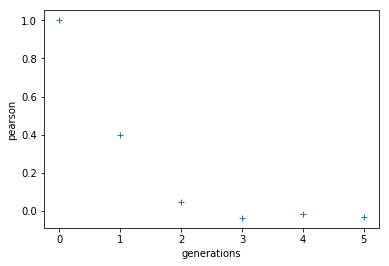

In [613]:
plt.plot(np.append(np.arange(1,6),0),np.append(corr_long[:,0],1),'+')
plt.xlabel('generations')
plt.ylabel('pearson')
plt.savefig('Correlation_Dany.png')

Look on sythetic 

In [617]:
bp = deep_array.iloc[2]

In [624]:
# Integrated (W) and simple Ou (X) for 10 lane (ncel) and 10 cell per lane (30*cell_per_lane)
cpl=40; lenc = 25; ncel = 30
W,X = rl.integrated_ou(mlam=bp['mlam'],gamma=bp['gamma'],sl2=bp['sl2'],sm2=bp['sm2'],length=30,ncel=10000)

Text(0.5, 1.0, 'Cv=0.15770133910012638')

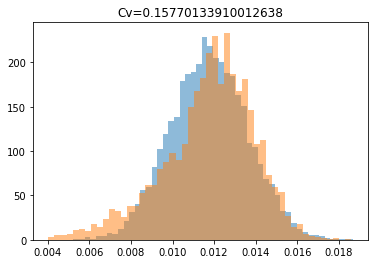

In [626]:
faelra = np.apply_along_axis(sleres,1,W)
plt.hist(faelra,bins=50,density=1,alpha=0.5)
plt.hist(elrat,bins=50,density=1,alpha=0.5)
plt.title('Cv={}'.format(np.std(faelra)/np.mean(faelra)))

In [640]:
cpl=40; lenc = 25; ncel = 20
W,X = rl.integrated_ou(mlam=bp['mlam'],gamma=bp['gamma'],sl2=bp['sl2'],sm2=0,length=cpl*lenc,ncel=ncel)
dfsy = smilar_frame(W,cpl,lenc,ncel,cvd=0.)
dfsy['leng'] = dfsy['leng'].apply(lambda x: np.exp(np.random.normal(np.log(x),np.sqrt(bp['sm2']))))
dfsy,in_dic_sy = rl.build_data_strucutre(dfsy,'leng',1)

In [641]:
dfsy['parent_cell'] = dfsy['lane_ID']+'_'+dfsy['parent_id']

In [642]:
dfsy = genalogy(dfsy,'parent_cell')

In [643]:
dfsy = genalogy(dfsy,'g_parent_cell')

In [645]:
elratsy = dfsy.groupby('cell').apply(lambda x: sleres(x.log_resc_leng))

In [647]:
corr_par(dfsy,elratsy,par_deg='parent_cell')

(-0.013700122015804228, 780)

In [648]:
corr_par(dfsy,elratsy,par_deg='g_parent_cell')

(-0.00848694032859666, 760)

Try even deeper sampling

In [ ]:
even_deeper = par_array(df,in_dic,gammas=1/np.linspace(100,500,50), sz = 2)

In [653]:
np.save('even_deeper.npy',even_deeper)

In [660]:
even_deep_array = pd.DataFrame(np.vstack((deep_array,even_deeper)),columns=('mlam','gamma','sl2','sm2','log_lik'))

In [662]:
even_deep_array['tau']=1/even_deep_array['gamma']

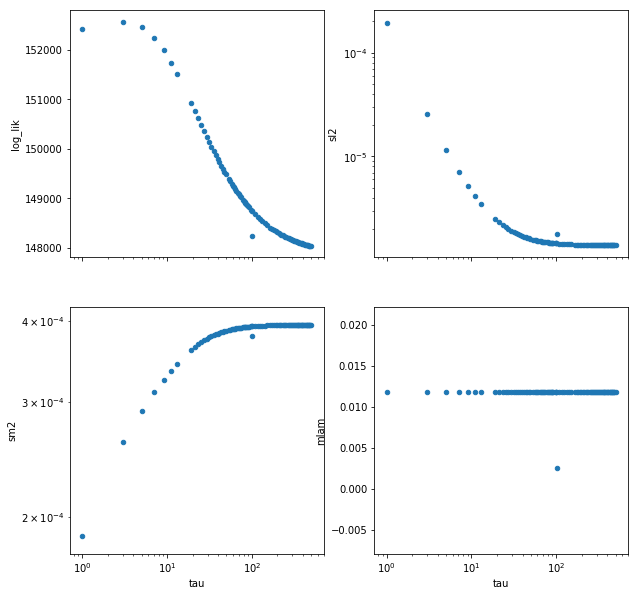

In [818]:
pdfilt = even_deep_array.loc[even_deep_array['log_lik']>144000]
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)
pdfilt.plot(x='tau',y='log_lik',kind='scatter',logx=True,ax=axs[0,0],sharex=True)
pdfilt.plot(x='tau',y='sl2',kind='scatter',logx=True,logy=True,ax=axs[0,1],sharex=True)
pdfilt.plot(x='tau',y='sm2',kind='scatter',logx=True,logy=True,ax=axs[1,0],sharex=True)
pdfilt.plot(x='tau',y='mlam',kind='scatter',logx=True,logy=False,ax=axs[1,1],sharex=True)
fig.savefig('even_deeper.png')

# Some figure for GM to be than delete

In [721]:
dfpr = df.loc[df['touch_bottom']==True]

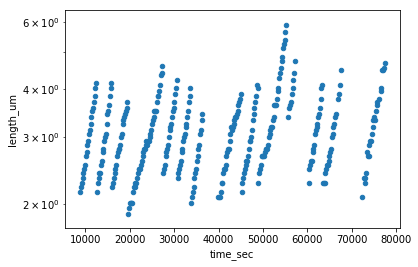

In [735]:
dfpr.loc[(dfpr['lane_ID']=='myframes_chr_hi1_glucose_20190515pos_0_GL_02')].plot(x='time_sec',y='length_um',logy=True,kind='scatter')
plt.savefig('bottom_cells.png')

In [737]:
dfsh = df.loc[(df['lane_ID']=='myframes_chr_hi1_glucose_20190515pos_0_GL_02')]

In [738]:
dfsh,in_dic_sh = rl.build_data_strucutre(dfsh,'length_um',1)

In [ ]:
short_lane = par_array(dfsh,in_dic_sh,gammas=1/np.linspace(1,500,50), sz = 2)

In [771]:
plt.subplot?

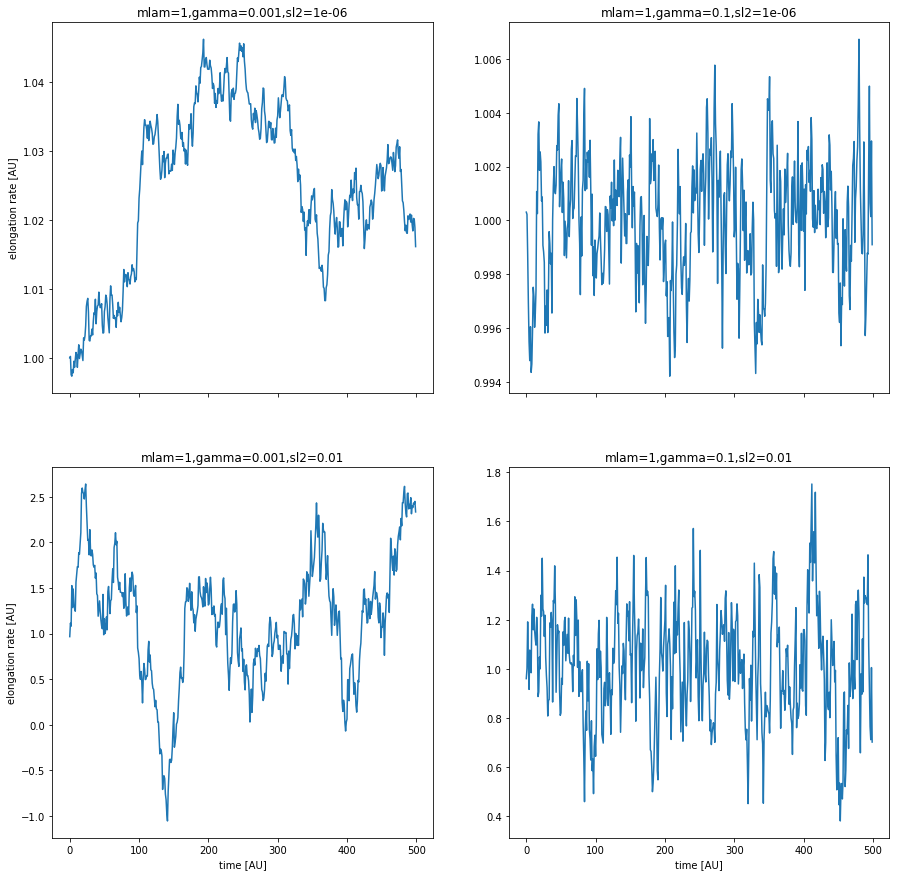

In [790]:
fig, axs = plt.subplots(ncols=2,nrows=2,sharex=True)
fig.set_figheight(15)
fig.set_figwidth(15)
t=range(500)
_,X = rl.integrated_ou(mlam=1,gamma=.001,sl2=1e-06,sm2=0,length=500,ncel=1)
axs[0,0].plot(t, X.reshape(-1))
axs[0,0].set_title('mlam={},gamma={},sl2={}'.format(1,.001,1e-06))
_,X = rl.integrated_ou(mlam=1,gamma=.1,sl2=1e-06,sm2=0,length=500,ncel=1)
axs[0,1].plot(t, X.reshape(-1))
axs[0,1].set_title('mlam={},gamma={},sl2={}'.format(1,.1,1e-06))
_,X = rl.integrated_ou(mlam=1,gamma=.001,sl2=1e-02,sm2=0,length=500,ncel=1)
axs[1,0].plot(t, X.reshape(-1))
axs[1,0].set_title('mlam={},gamma={},sl2={}'.format(1,.001,1e-02))
_,X = rl.integrated_ou(mlam=1,gamma=.1,sl2=1e-02,sm2=0,length=500,ncel=1)
axs[1,1].plot(t, X.reshape(-1))
axs[1,1].set_title('mlam={},gamma={},sl2={}'.format(1,.1,1e-02))
axs[1,0].set_xlabel('time [AU]')
axs[0,0].set_ylabel('elongation rate [AU]')
axs[1,1].set_xlabel('time [AU]')
axs[1,0].set_ylabel('elongation rate [AU]')
plt.savefig('ou_proc_ex.png')

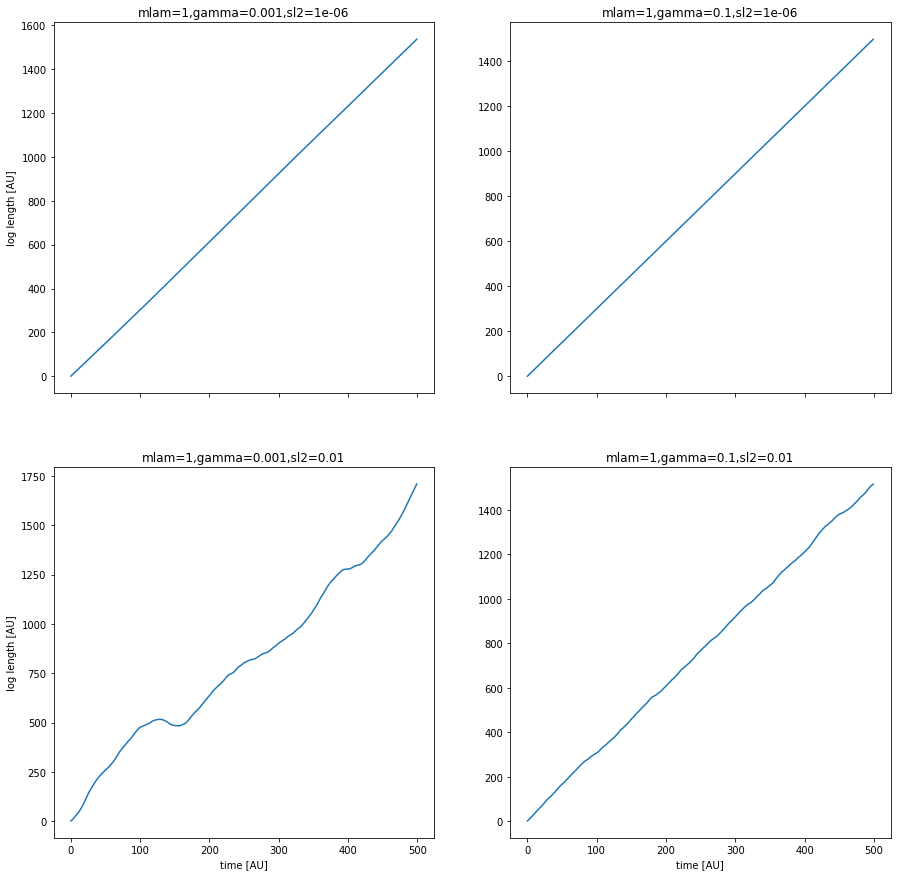

In [794]:
np.random.seed(4)
fig, axs = plt.subplots(ncols=2,nrows=2,sharex=True)
fig.set_figheight(15)
fig.set_figwidth(15)
t=range(500)
X,_ = rl.integrated_ou(mlam=1,gamma=.001,sl2=1e-06,sm2=0,length=500,ncel=1)
axs[0,0].plot(t, X.reshape(-1),)
axs[0,0].set_title('mlam={},gamma={},sl2={}'.format(1,.001,1e-06))
X,_ = rl.integrated_ou(mlam=1,gamma=.1,sl2=1e-06,sm2=0,length=500,ncel=1)
axs[0,1].plot(t, X.reshape(-1))
axs[0,1].set_title('mlam={},gamma={},sl2={}'.format(1,.1,1e-06))
X,_ = rl.integrated_ou(mlam=1,gamma=.001,sl2=1e-02,sm2=0,length=500,ncel=1)
axs[1,0].plot(t, X.reshape(-1))
axs[1,0].set_title('mlam={},gamma={},sl2={}'.format(1,.001,1e-02))
X,_ = rl.integrated_ou(mlam=1,gamma=.1,sl2=1e-02,sm2=0,length=500,ncel=1)
axs[1,1].plot(t, X.reshape(-1))
axs[1,1].set_title('mlam={},gamma={},sl2={}'.format(1,.1,1e-02))
axs[1,0].set_xlabel('time [AU]')
axs[0,0].set_ylabel('log length [AU]')
axs[1,1].set_xlabel('time [AU]')
axs[1,0].set_ylabel('log length [AU]')
plt.savefig('int_ou_proc_ex.png')

/scicore/home/nimwegen/fiori/MoMA_predictions/MoMa_pred/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


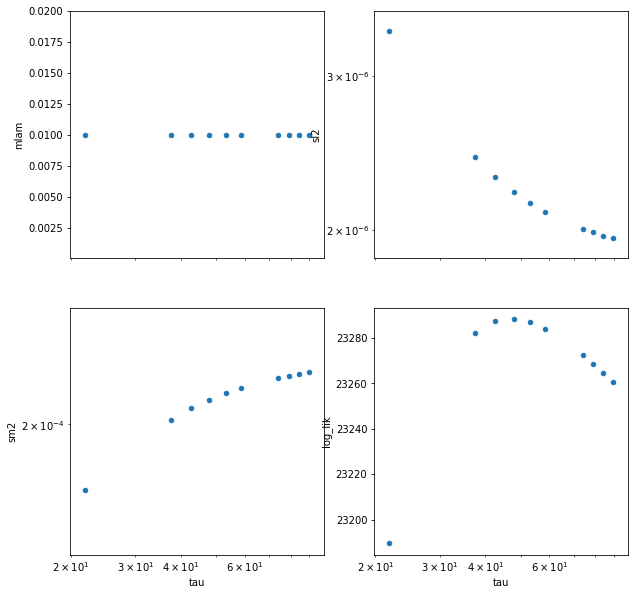

In [799]:
asy_cdv03 = np.load('asy_cdv0.npy')
asy_cdv03_array = pd.DataFrame(asy_cdv03,columns=('mlam','gamma','sl2','sm2','log_lik'))
pdfilt = asy_cdv03_array.loc[asy_cdv03_array['log_lik']>22750,:]
pdfilt['tau']=1/pdfilt['gamma']
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)
pdfilt.plot(x='tau',y='log_lik',kind='scatter',logx=True,ax=axs[1,1],sharex=True)
pdfilt.plot(x='tau',y='sl2',kind='scatter',logx=True,logy=True,ax=axs[0,1],sharex=True)
pdfilt.plot(x='tau',y='sm2',kind='scatter',logx=True,logy=True,ax=axs[1,0],sharex=True)
pdfilt.plot(x='tau',y='mlam',kind='scatter',logx=True,logy=False,ax=axs[0,0],sharex=True)
#plt.vlines(50,15000,16000)
fig.savefig('asy_cdv0.png')

In [819]:
dedear = np.vstack((deep_array,even_deeper))

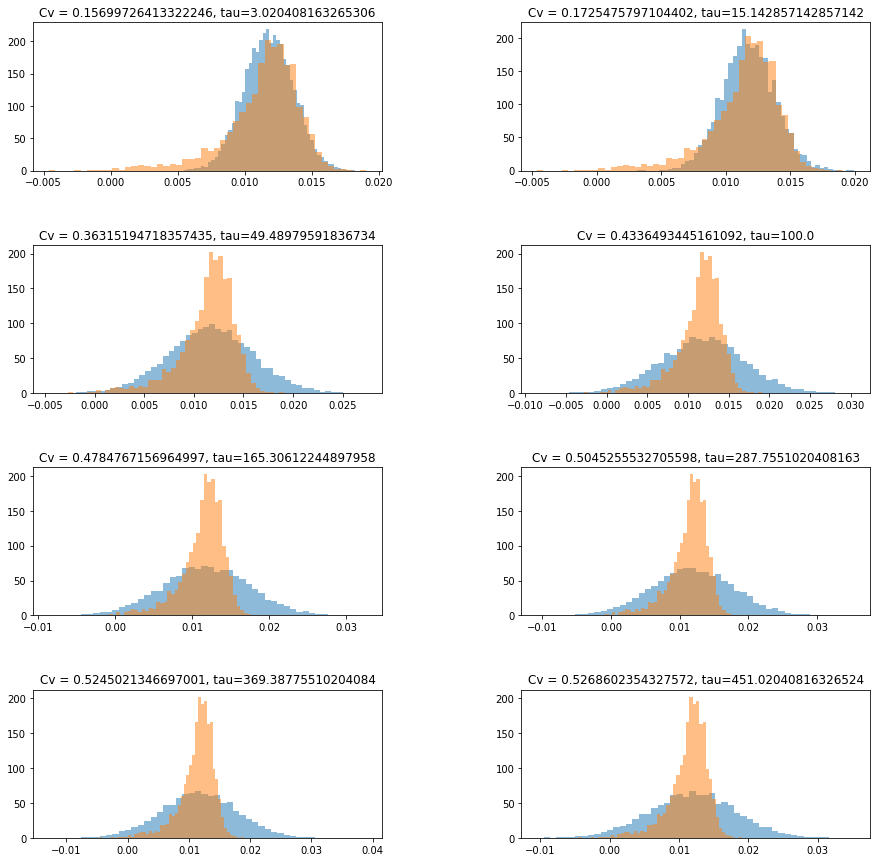

In [1182]:
thcvsim = []
nwa= np.vstack((dedear[2,:],dedear[8,:],dedear[25,:],dedear[50,:],dedear[60,:],dedear[75,:],dedear[85,:],dedear[95,:]))
tmp = synt_stats_old(nwa)
fig, axs = plt.subplots(nrows=4,ncols=2)
fig.set_figwidth(15)
fig.set_figheight(15)
plt.subplots_adjust(wspace=0.4,hspace=0.5)
i=j=0
for k in range(tmp.shape[0]):    
    axs[i,j].hist(tmp[k,:],bins=50,density=1,alpha=0.5)
    axs[i,j].hist(elrat,bins=50,density=1,alpha=0.5)
    thcvsim.append(np.std(tmp[k,:])/np.mean(tmp[k,:]))
    axs[i,j].set_title("Cv = {}, tau={}".format(np.std(tmp[k,:])/np.mean(tmp[k,:]),1/nwa[k,1]))
    if j%2==0:
        j=1
    else:
        i+=1; j=0
fig.savefig('simulated_ou_proc')

/scicore/home/nimwegen/fiori/MoMA_predictions/MoMa_pred/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


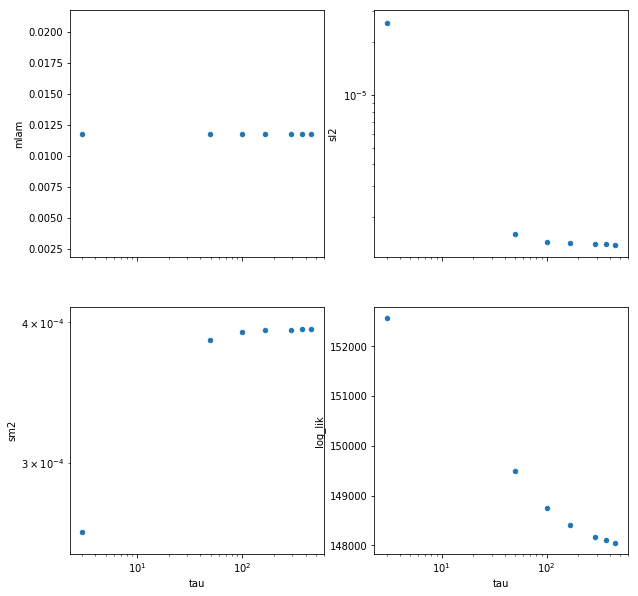

In [856]:
asy_cdv03_array = pd.DataFrame(nwa,columns=('mlam','gamma','sl2','sm2','log_lik'))
pdfilt = asy_cdv03_array.loc[asy_cdv03_array['log_lik']>0,:]
pdfilt['tau']=1/pdfilt['gamma']
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)
pdfilt.plot(x='tau',y='log_lik',kind='scatter',logx=True,ax=axs[1,1],sharex=True)
pdfilt.plot(x='tau',y='sl2',kind='scatter',logx=True,logy=True,ax=axs[0,1],sharex=True)
pdfilt.plot(x='tau',y='sm2',kind='scatter',logx=True,logy=True,ax=axs[1,0],sharex=True)
pdfilt.plot(x='tau',y='mlam',kind='scatter',logx=True,logy=False,ax=axs[0,0],sharex=True)
#plt.vlines(50,15000,16000)
fig.savefig('sim_proc_param.png')

In [1190]:
def syntetic_corr_gen(mlam,gamma,sl2,sm2):
    cpl=40; lenc = 25; ncel = 20
    W,X = rl.integrated_ou(mlam,gamma,sl2,sm2=0,length=cpl*lenc,ncel=ncel)
    dfsy = smilar_frame(W,cvd=0.)
    dfsy['leng'] = dfsy['leng'].apply(lambda x: np.exp(np.random.normal(np.log(x),np.sqrt(sm2))))
    dfsy,in_dic_sy = rl.build_data_strucutre(dfsy,'leng',1)
    dfsy['parent_cell'] = dfsy['lane_ID']+'_'+dfsy['parent_id']
    dfsy = genalogy(dfsy,'parent_cell')
    dfsy = genalogy(dfsy,'g_parent_cell')
    dfsy = genalogy(dfsy,'g_g_parent_cell')
    dfsy = genalogy(dfsy,'g_g_g_parent_cell')
    elratsy = dfsy.groupby('cell').apply(lambda x: sleres(x.log_resc_leng))
    corr_long = np.vstack([corr_par(dfsy,elratsy,par_deg=k) for k in ['parent_cell','g_parent_cell','g_g_parent_cell','g_g_g_parent_cell','g_g_g_g_parent_cell'] ])
    return corr_long

In [1193]:
corr_long = [syntetic_corr_gen(nwa[k,0],nwa[k,1],nwa[k,2],nwa[k,3]) for k in range(nwa.shape[0])]

In [1208]:
corr_long[0][:,0]

array([-0.03258463, -0.03736694,  0.0043586 ,  0.01447181, -0.00051749])

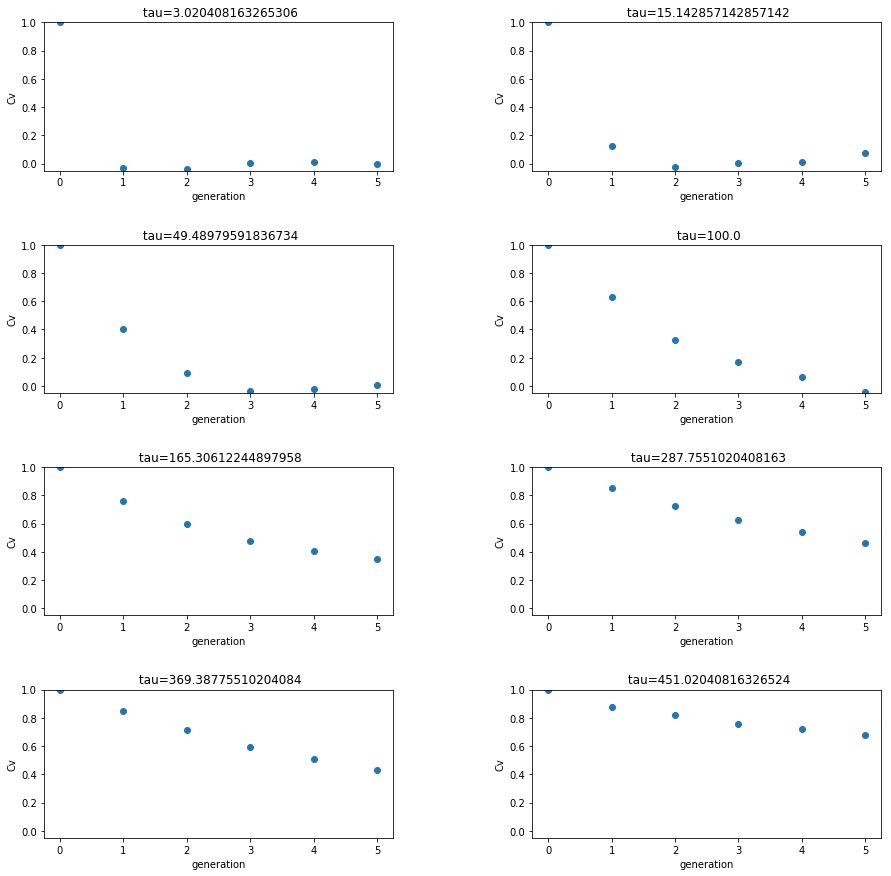

In [1212]:
fig, axs = plt.subplots(nrows=4,ncols=2)
fig.set_figwidth(15)
fig.set_figheight(15)
plt.subplots_adjust(wspace=0.4,hspace=0.5)
i=j=0
for k in range(len(corr_long)):    
    axs[i,j].plot(np.append(np.arange(1,len(corr_long[k])+1),0),np.append(corr_long[k][:,0],1),'o')
    axs[i,j].set_title(" tau={}".format(1/nwa[k,1]))
    axs[i,j].set_ylim([-0.05,1])
    axs[i,j].set_xlabel("generation")
    axs[i,j].set_ylabel("Cv")
    if j%2==0:
        j=1
    else:
        i+=1; j=0
fig.savefig('sim_ge_corr.png')

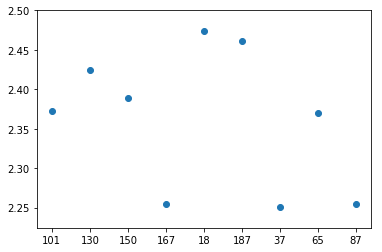

In [1087]:
W,X = rl.integrated_ou(nwa[k,0],nwa[k,1],nwa[k,2],sm2=0,length=200,ncel=1)
dfpr = smilar_frame_cor(W,cvd=0)
qq = dfpr.loc[dfpr['lane_ID']=='lane_num_0'].groupby('id')['leng'].first()

plt.scatter(qq.index,qq.values)

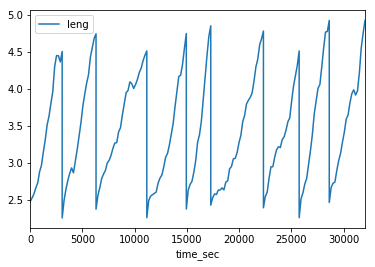

In [1088]:
dfpr.plot(x='time_sec',y='leng',logy=False)

In [1084]:
df.groupby('cell')['length_um'].first().mean()

1.9765373725934312

In [1100]:
banfs = np.load('best_array_no_filter_shor.npy')

In [1101]:
banfs

array([[ 8.15864908e-03,  9.94635157e-03,  1.00000000e-13,
         4.05743960e-05, -9.22512763e+05],
       [ 1.17539158e-02,  1.00000000e-01,  4.62755389e-06,
         3.29776625e-04,  1.51874548e+05]])

In [1111]:
tmp = synt_stats_old(np.array([[1.0917e-02,1.721,5.24e-04,1.73e-04]]))

In [1113]:
np.std(tmp)/np.mean(tmp)

0.4043935925603591

In [1116]:
np.mean(df.groupby('cell')['time_sec'].last()-df.groupby('cell')['time_sec'].first())/60

56.75877689694224

In [1118]:
dedear[2,:]

array([1.17539158e-02, 3.31081081e-01, 2.56017627e-05, 2.60470092e-04,
       1.52570202e+05])

In [1121]:
def thcv(la,ga,sl2,t):
    vt = sl2/(2*ga**3)*(2*ga*t-3+4*np.exp(-ga*t)-np.exp(-2*ga*t))
    vt = vt/t**2
    return np.sqrt(vt)/la

In [1166]:
thcv(1.17539158e-02, 3.31081081e-01, 2.56017627e-05,90)

0.13356134416183463

In [ ]:
dedear[2,:],dedear[8,:],dedear[25,:],dedear[50,:],dedear[60,:],dedear[75,:],dedear[85,:],dedear[95,:]

In [1178]:
thcf = [thcv(dedear[k,:][0],dedear[k,:][1],dedear[k,:][2],90) for k in [2,8,25,50,60,75,85,95]]

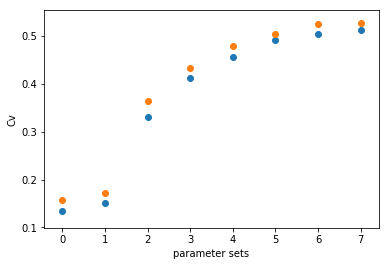

In [1187]:
plt.scatter(range(len(thcf)),thcf)
plt.scatter(range(len(thcf)),thcvsim)
plt.xlabel('parameter sets')
plt.ylabel('Cv')
plt.savefig('cv_the_sim.png')

In [1186]:
thcf

[0.13356134462743188,
 0.15089110159210112,
 0.3308162209571493,
 0.4115559702311634,
 0.45678522958957773,
 0.4922522806312949,
 0.5038878372142959,
 0.5115982947733828]

In [1218]:
1/6.5e-02

15.384615384615383

In [1226]:
np.append(np.array([0.01,0.02,2e-06,2e-04]),corr_err_large[4,:-1]).reshape((2,4))

array([[1.00000000e-02, 2.00000000e-02, 2.00000000e-06, 2.00000000e-04],
       [1.00791008e-02, 6.01265823e-02, 8.83244564e-06, 2.32081030e-04]])

In [ ]:
nwa = np.append(np.array([0.01,0.02,2e-06,2e-04]),corr_err_large[4,:-1]).reshape((2,4))
tmp = synt_stats_old(nwa)

In [1241]:
corr_err_large[4,:-1][None,:]

array([[1.00791008e-02, 6.01265823e-02, 8.83244564e-06, 2.32081030e-04]])

In [1252]:
np.save('/scicore/home/nimwegen/fiori/MoMA_predictions/tmp0.npy',tmp0)

In [1253]:
np.save('/scicore/home/nimwegen/fiori/MoMA_predictions/tmp1.npy',tmp1)

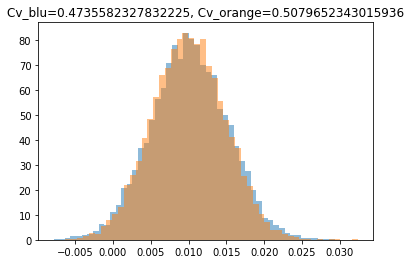

In [1298]:
#tmp1 = synt_stats_with_noise(np.array([0.01,0.02,2e-06,2e-04])[None,:])
#tmp0 = synt_stats_old(corr_err_large[4,:-1][None,:])
_=plt.hist(tmp0.reshape(-1),bins=50,density=1,alpha=0.5)
_=plt.hist(tmp1.reshape(-1),bins=50,density=1,alpha=0.5)
plt.title('Cv_blu={}, Cv_orange={}'.format(np.std(tmp[0,:])/np.mean(tmp[0,:]),np.std(tmp[1,:])/np.mean(tmp[1,:])))
plt.savefig('dist_with_corr_noise_and_without')

In [1296]:
def synt_stats_with_noise(abv,noisegam=0.1):
    ret=[]
    for j in range(abv.shape[0]):
        W,X = rl.integrated_ou(mlam=abv[j,0],gamma=abv[j,1],sl2=abv[j,2],sm2=0,length=30,ncel=10000)
        Xerr = rl.ornstein_uhlenbeck(mlam=0.,gamma=noisegam,sl2=abv[j,3],length=30,ncel=10000)
        W = W+Xerr
        la = np.apply_along_axis(sleres,1,W)
        ret.append(la)       
    return np.vstack(ret)

# Look the shape of the log likelihood

In [1491]:
def mesh_grid( num_point,in_dic):
    """Build heat maps where center_point (cp) is the estimate parameters  """
    mus = np.linspace(0.08,1.5,num_point)*in_dic['rescale']
    gam = 1/np.geomspace(0.1,100,num_point)
    sl2 = np.geomspace(1e-08,1e-06,num_point)*in_dic['rescale']**2
    sm2 = np.geomspace(1e-05,1e-03,num_point)*in_dic['rescale']**2
    return np.meshgrid(gam,sl2)

In [1468]:
def fun_gsl(gammas,sl2s):
    ret=[]
    fun = lambda ga,sl2:  rl.grad_obj_wrap([in_dic['s'][1,0],ga,sl2,in_dic['sm2']],in_dic)[0]
    for g,sl2 in zip(gammas.reshape(-1),sl2s.reshape(-1)):
        ret.append(fun(g,sl2))
    return np.array(ret).reshape(gammas.shape)

Maximum log likelihood (normalized)

In [1553]:
mod = mn.minimize_lengths(free={'sl2':sl2*10,'sm2':sm2*9,'gamma':gam*10,},fixed={'m_lam':in_dic['s'][1,0]})
print(mod.minimize(in_dic=in_dic,numerical=False,fun=rl.grad_obj_wrap))

{'jac': array([ 6.20756050e+05, -2.17827241e-01,  1.58733585e+03, -1.13388471e+02]), 'success': True, 'best_param': {'sl2': 2.474155783898401e-05, 'mlam': 0.011753915754893067, 'gamma': 0.32436769635319923, 'sm2': 0.00026172368162996466}, 'log_lik': 2.1685477664400237, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'}


Load files where we compute ll for fix mlam and, for different sm2, we plot ll in function of sl2 and gamma

In [1631]:
names = pd.read_csv('/scicore/home/nimwegen/fiori/MoMA_predictions/grid_data/fixla_sm2_deep/names.txt',header=None)
names['sorted'] = [float(k[3:11]) for k in names[0]]
names = names.sort_values(by=['sorted'])

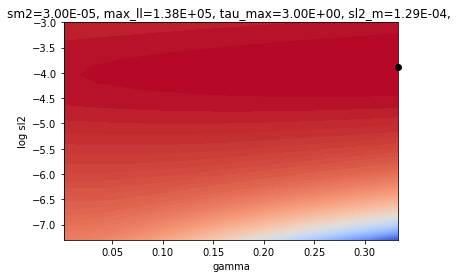

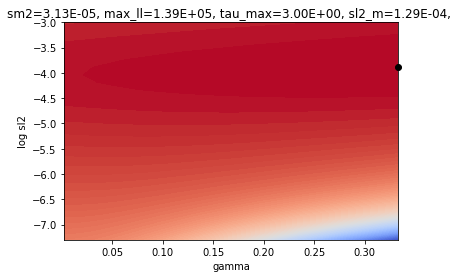

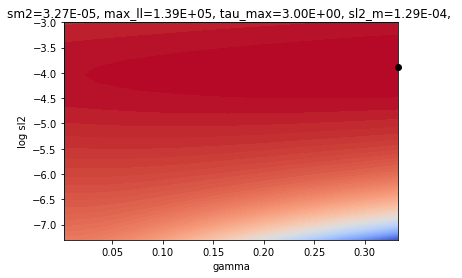

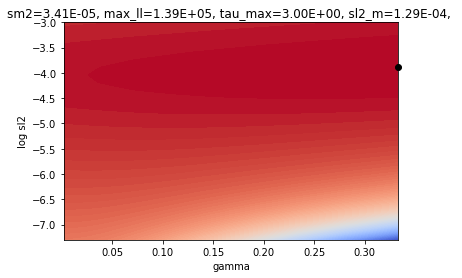

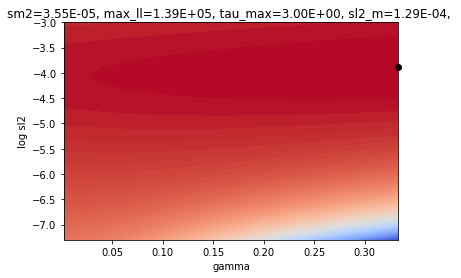

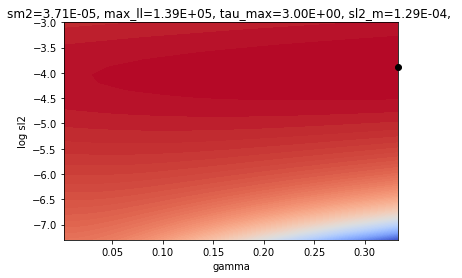

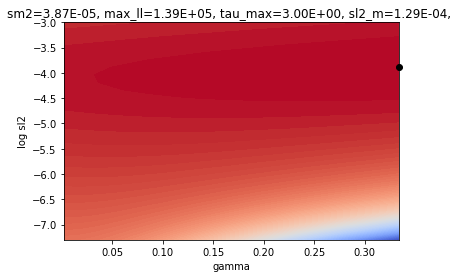

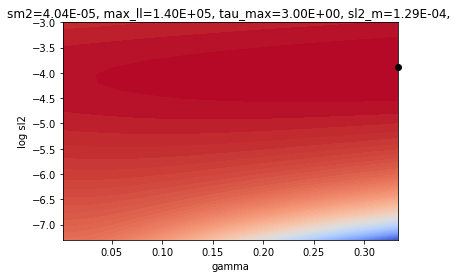

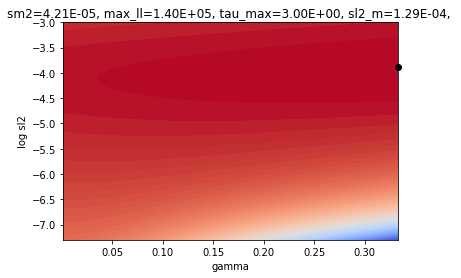

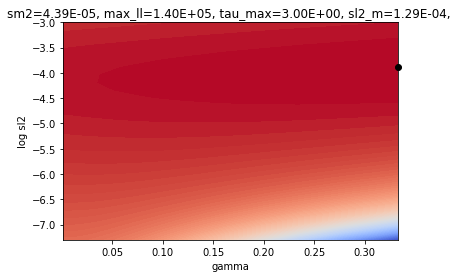

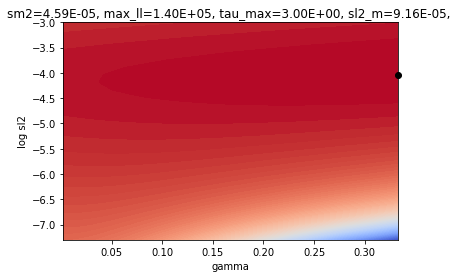

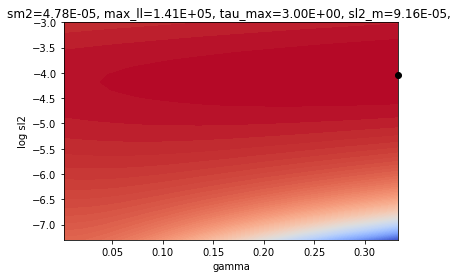

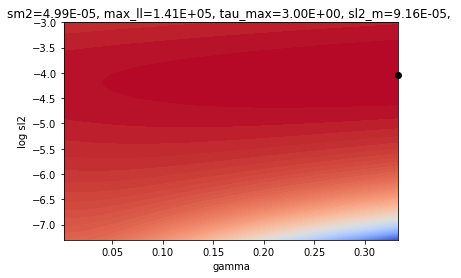

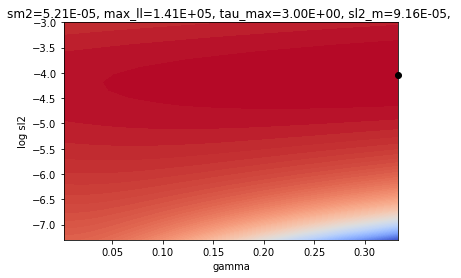

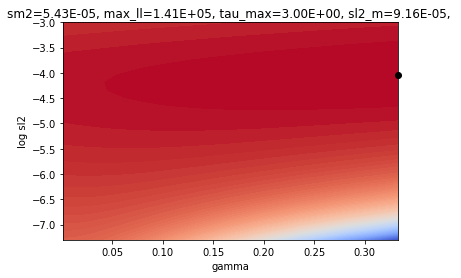

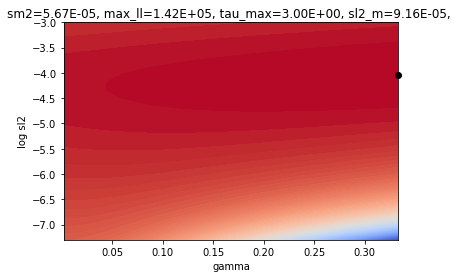

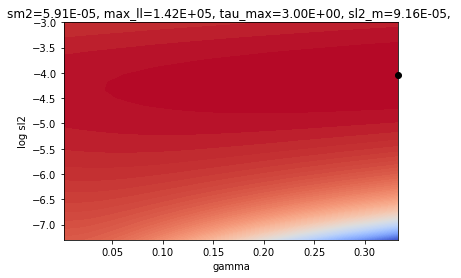

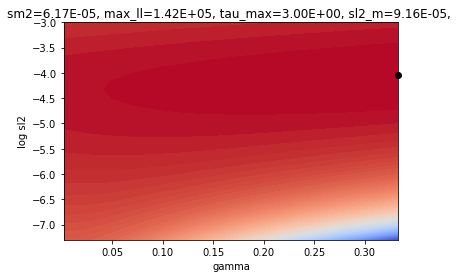

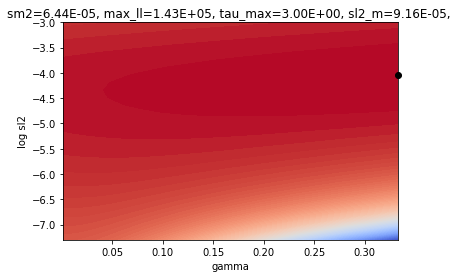

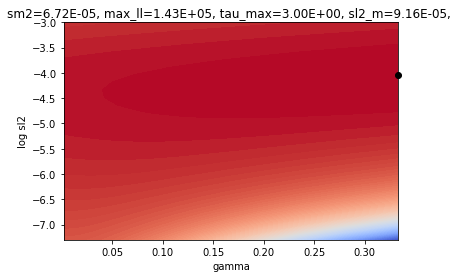

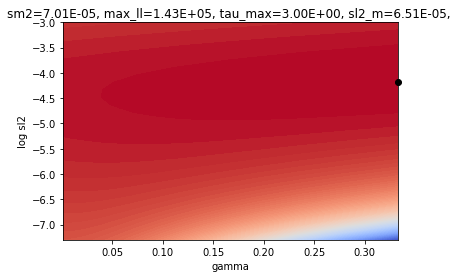

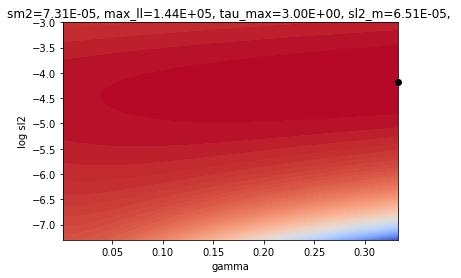

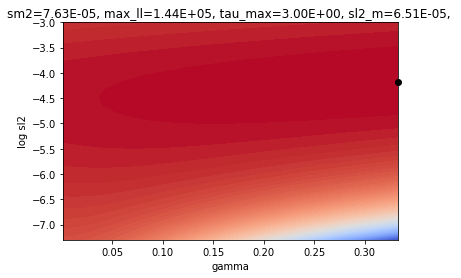

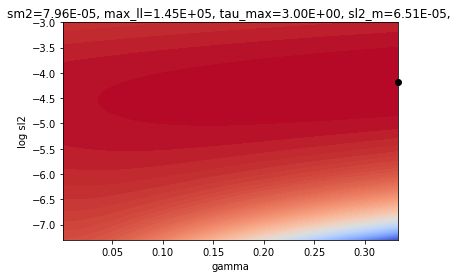

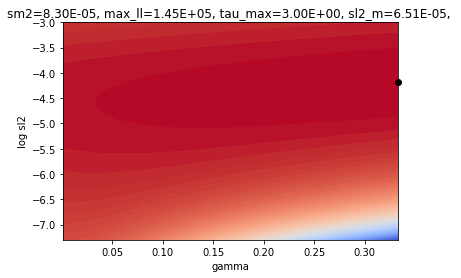

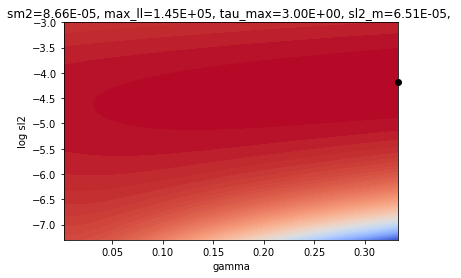

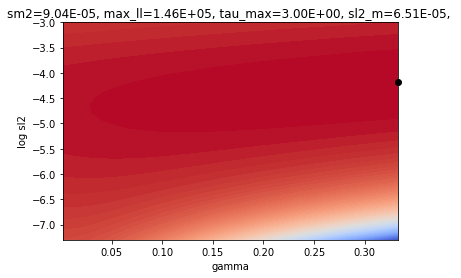

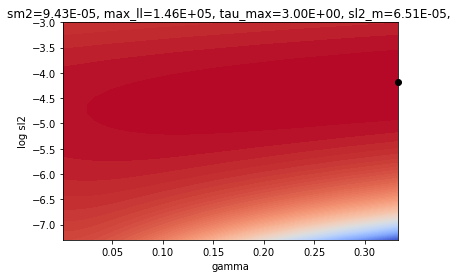

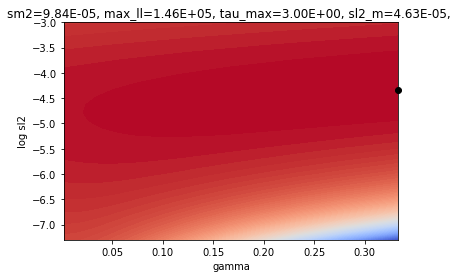

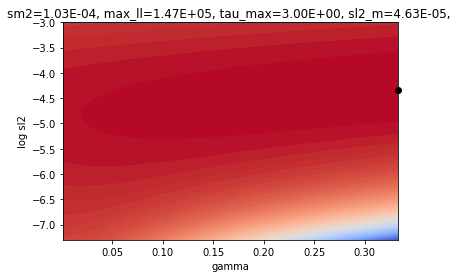

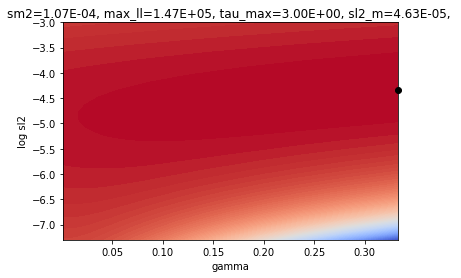

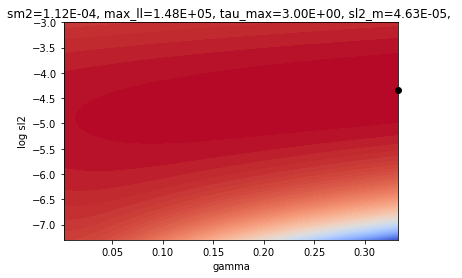

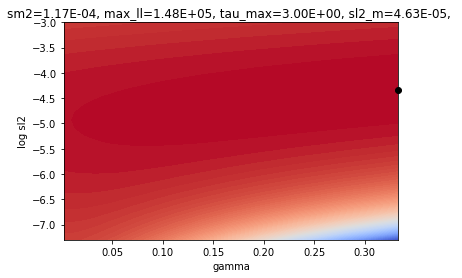

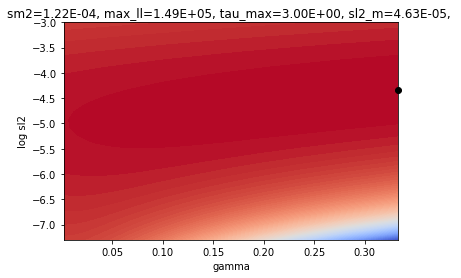

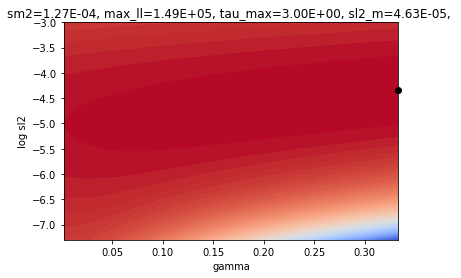

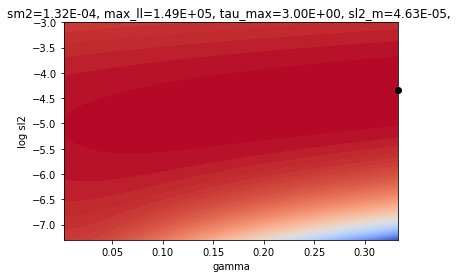

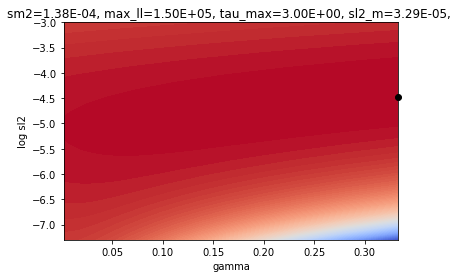

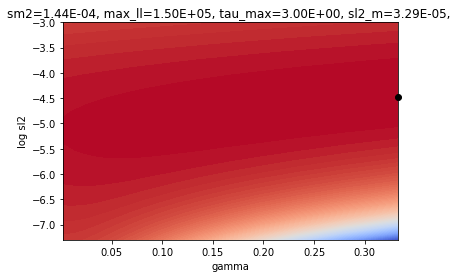

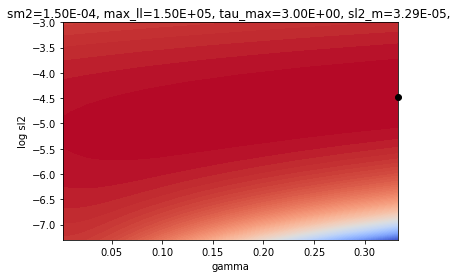

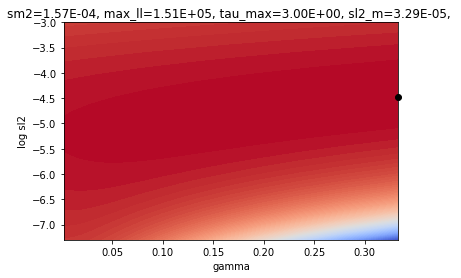

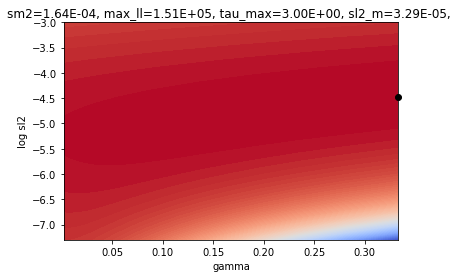

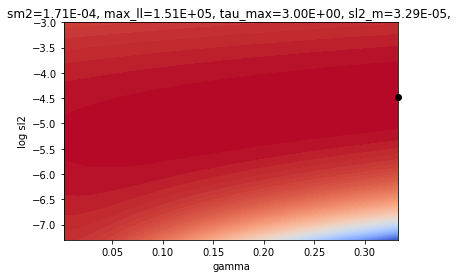

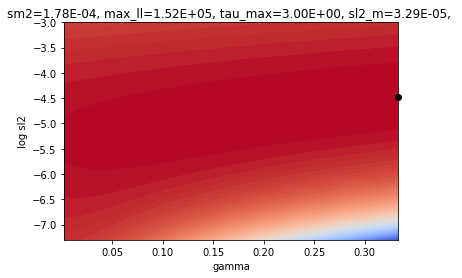

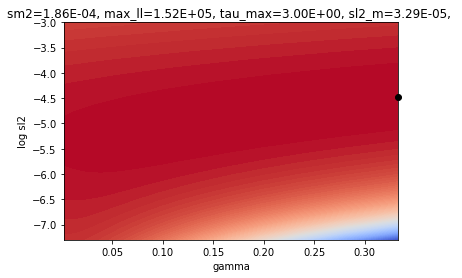

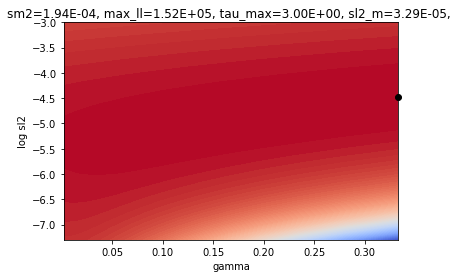

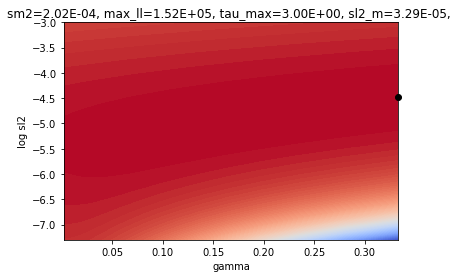

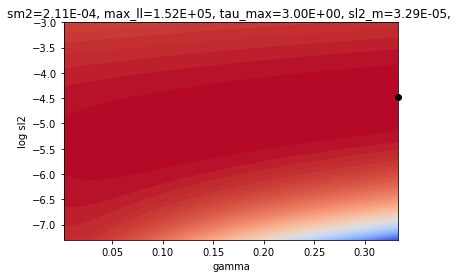

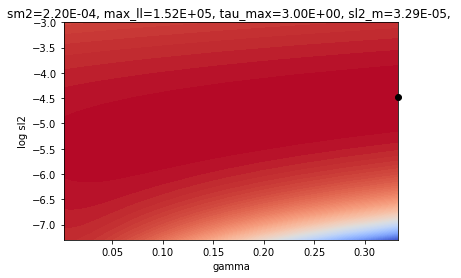

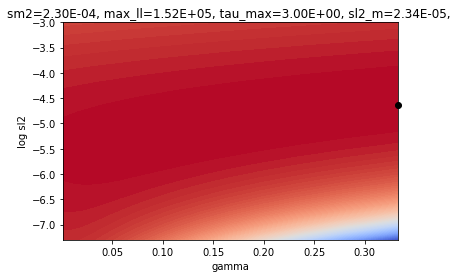

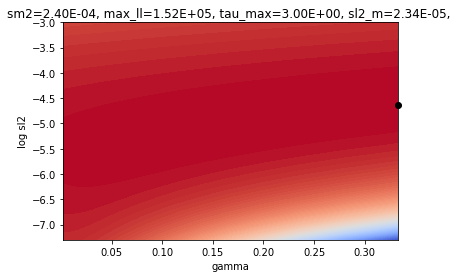

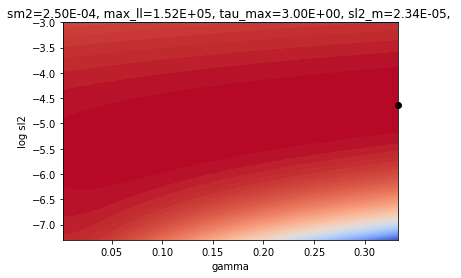

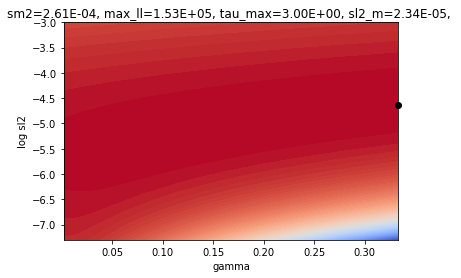

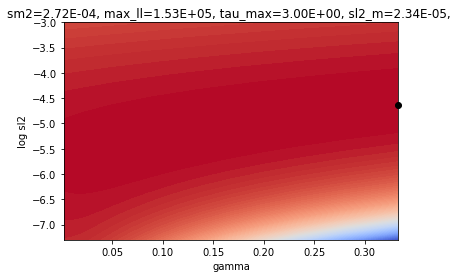

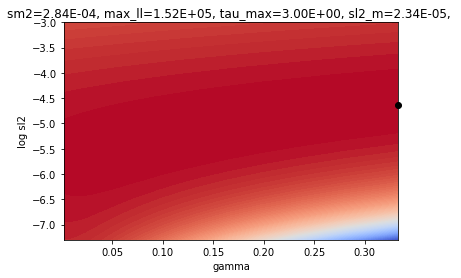

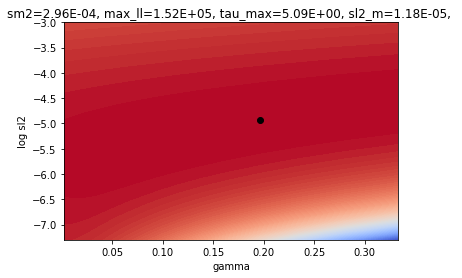

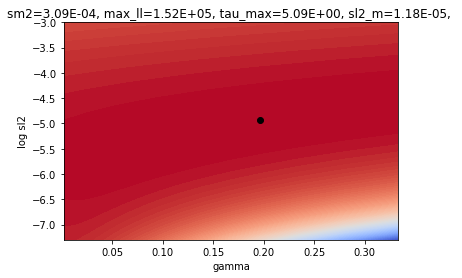

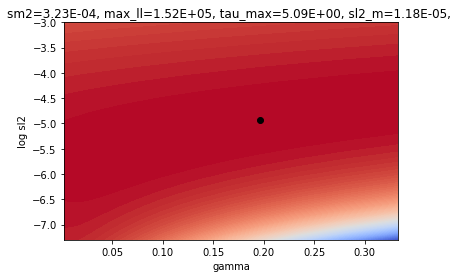

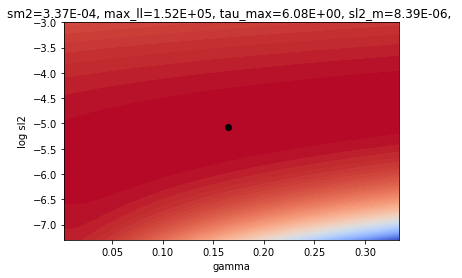

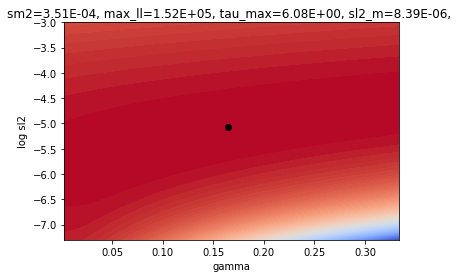

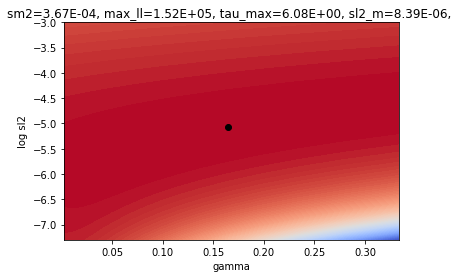

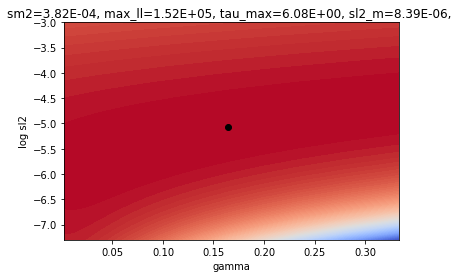

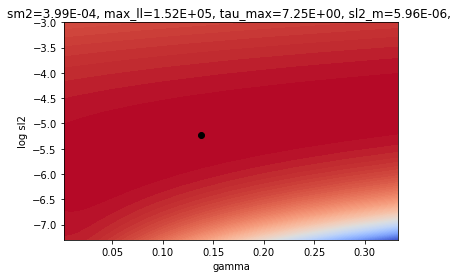

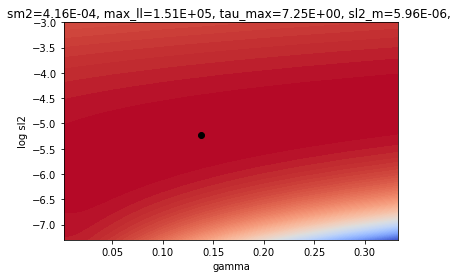

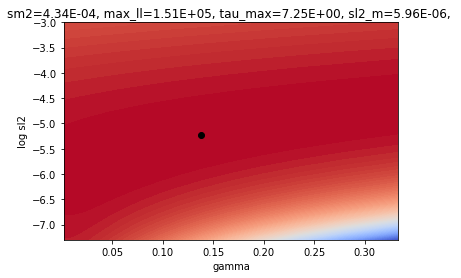

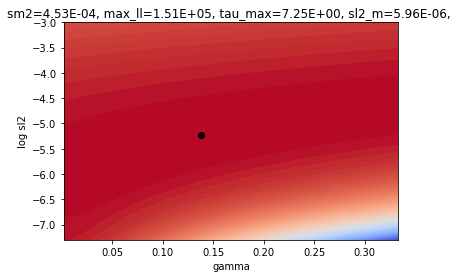

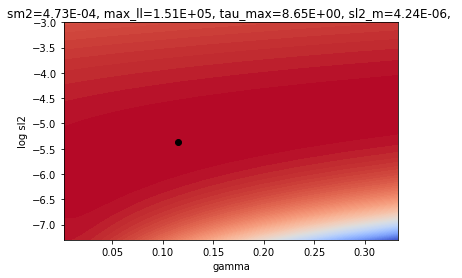

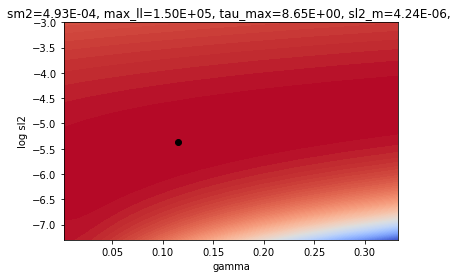

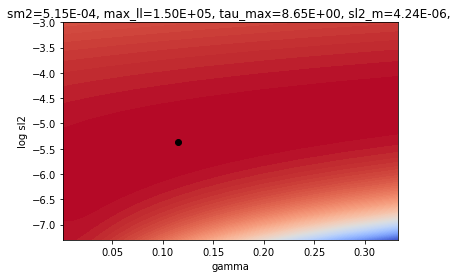

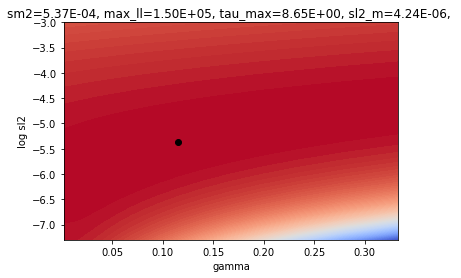

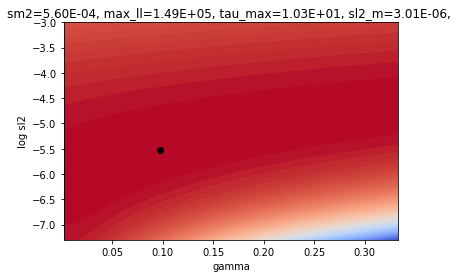

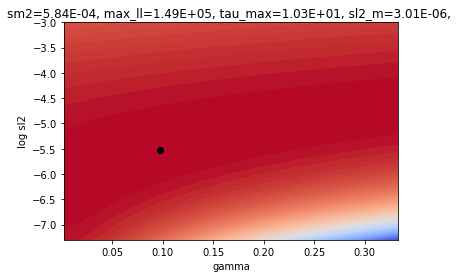

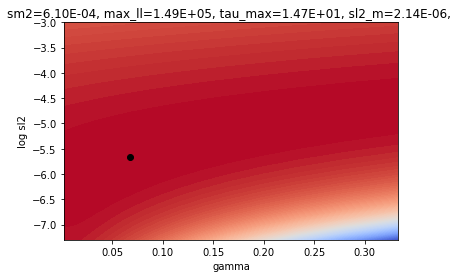

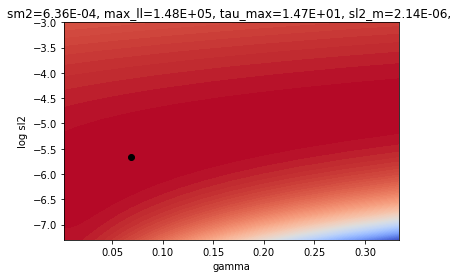

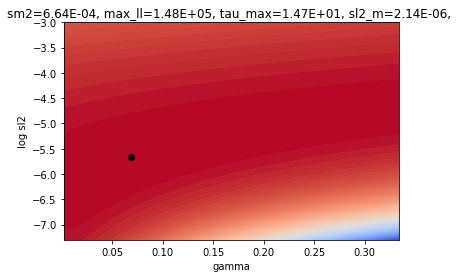

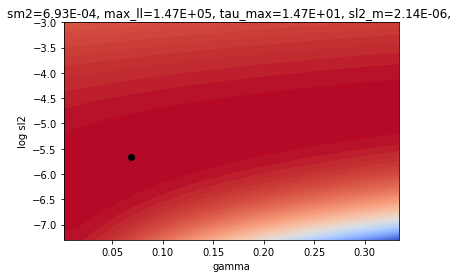

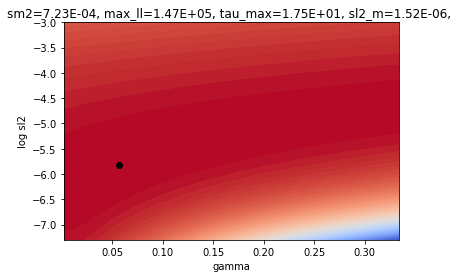

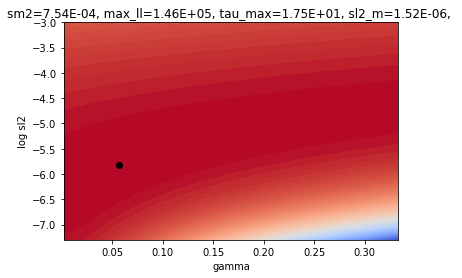

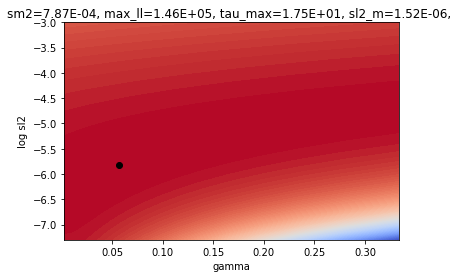

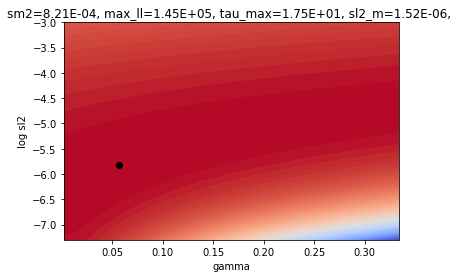

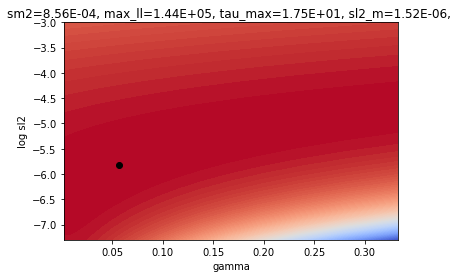

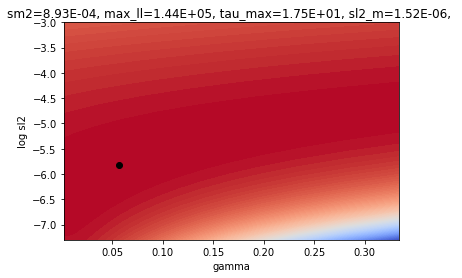

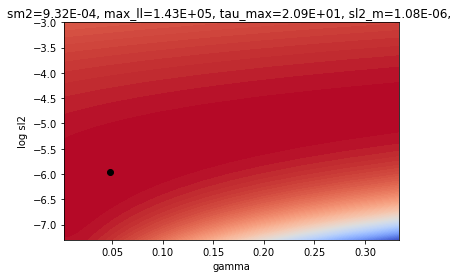

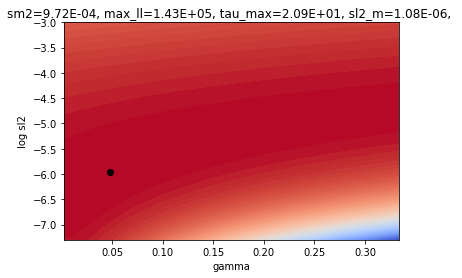

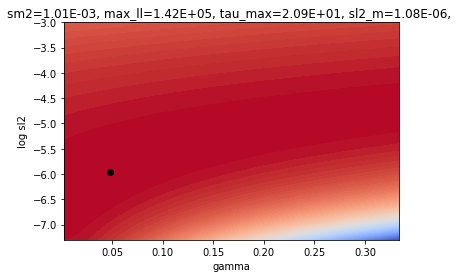

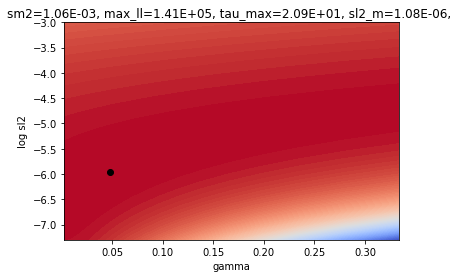

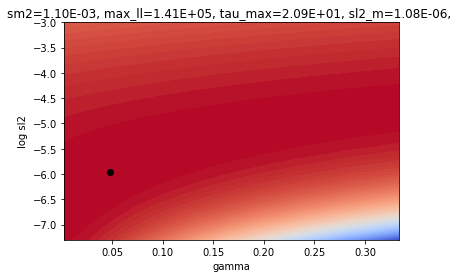

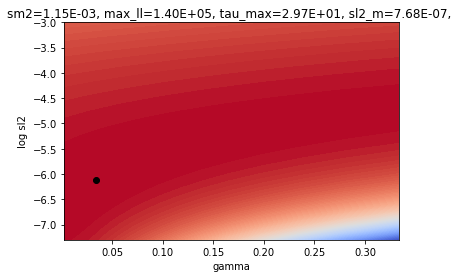

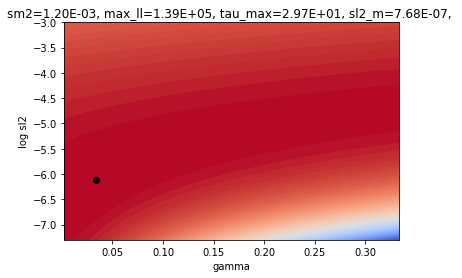

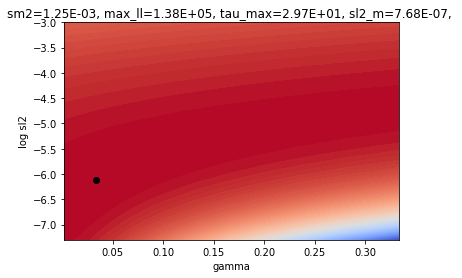

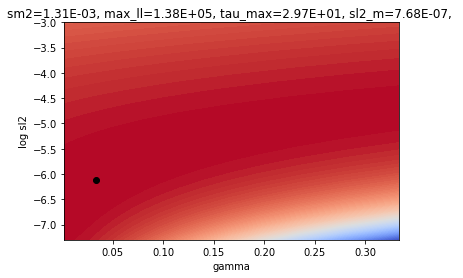

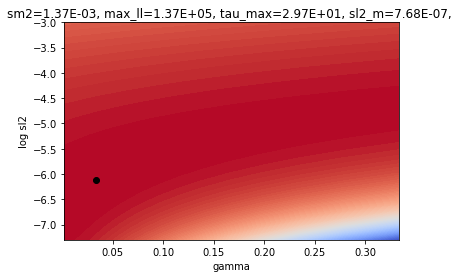

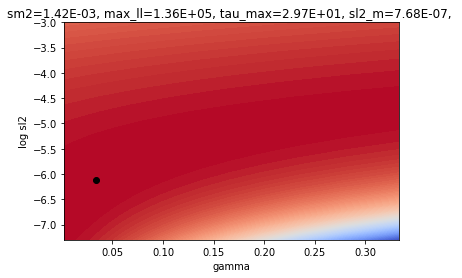

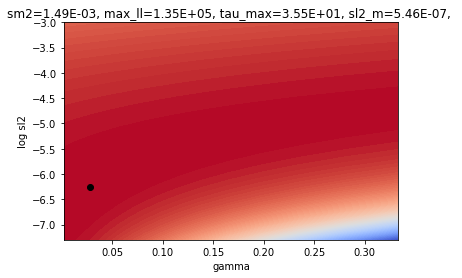

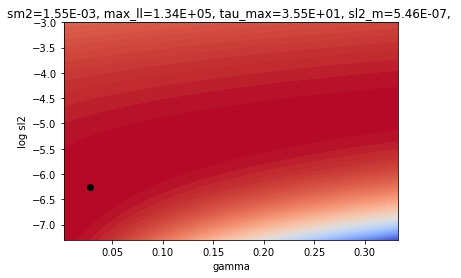

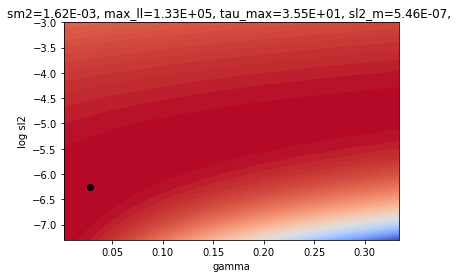

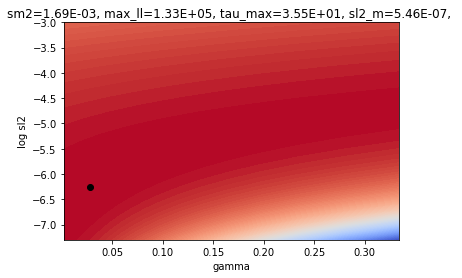

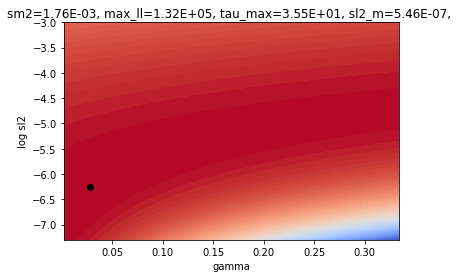

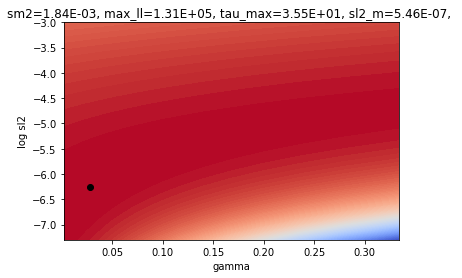

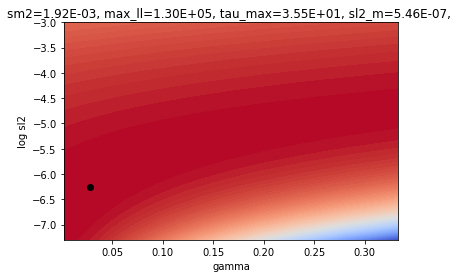

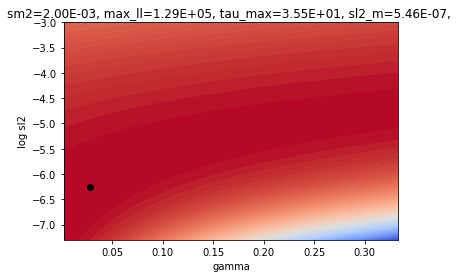

In [1668]:
gammas = np.load('/scicore/home/nimwegen/fiori/MoMA_predictions/grid_data/fixla_sm2_deep/gamma.npy')
sl2s = np.load('/scicore/home/nimwegen/fiori/MoMA_predictions/grid_data/fixla_sm2_deep/sl2.npy')
ls=0
for k in names.values:
    obj = np.load('/scicore/home/nimwegen/fiori/MoMA_predictions/grid_data/fixla_sm2_deep/'+k[0])
    lik = -obj
    q = np.argmax(lik)
    plt.contourf(gammas,np.log10(sl2s),lik,cmap=cm.coolwarm,levels=np.linspace(np.min(lik),np.max(lik),100))
    plt.plot(gammas.reshape(-1)[q],np.log10(sl2s.reshape(-1)[q]), color="black", marker = "o", zorder = 10, 
                                       markersize=6, clip_on=False)
    plt.title('sm2='+k[0][3:11]+', max_ll={:.2E}, tau_max={:.2E}, sl2_m={:.2E}, '.format(np.max(lik),1/gammas.reshape(-1)[q],sl2s.reshape(-1)[q]))
    plt.xlabel('gamma')
    plt.ylabel('log sl2')
    plt.show()
    


Take a closer look in the region sm2 in [2.50e-04,2.96e-04] and sl2 in (10-6 10-4)

In [1691]:
slic = (np.log10(sl2s)>-6)&(np.log10(sl2s)<-4)

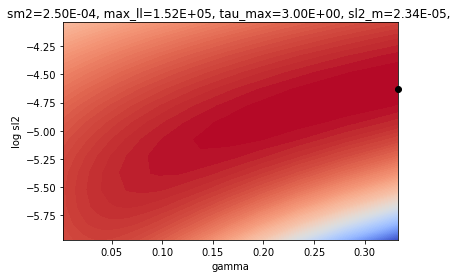

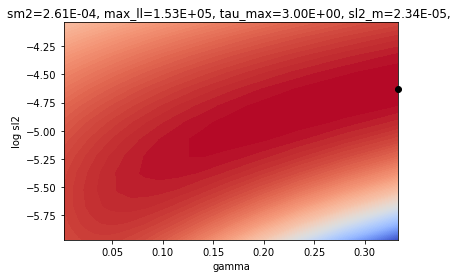

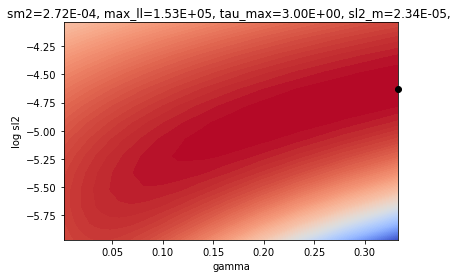

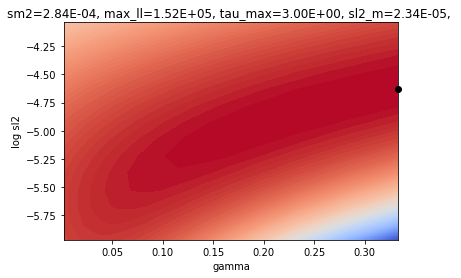

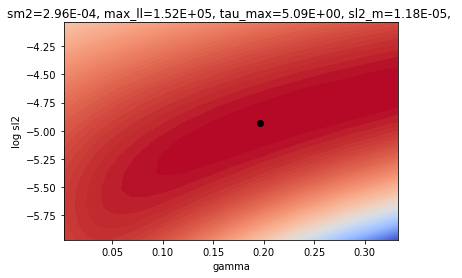

In [1709]:
for k in names.loc[(names['sorted']>=2.5e-04)&((names['sorted']<2.97e-04))].values:
    obj = np.load('/scicore/home/nimwegen/fiori/MoMA_predictions/grid_data/fixla_sm2_deep/'+k[0])
    lik = -obj
    q = np.argmax(lik)
    plt.contourf(gammas[slic].reshape(14,30),np.log10(sl2s[slic].reshape(14,30)),lik[slic].reshape(14,30),cmap=cm.coolwarm,levels=np.linspace(np.min(lik[slic]),np.max(lik),100))
    plt.plot(gammas.reshape(-1)[q],np.log10(sl2s.reshape(-1)[q]), color="black", marker = "o", zorder = 10, 
                                       markersize=6, clip_on=False)
    plt.title('sm2='+k[0][3:11]+', max_ll={:.2E}, tau_max={:.2E}, sl2_m={:.2E}, '.format(np.max(lik),1/gammas.reshape(-1)[q],sl2s.reshape(-1)[q]))
    plt.xlabel('gamma')
    plt.ylabel('log sl2')
    plt.show()
    

Start to fix the asymmetric division first and see if something changes what happens 